# Objective & Overview
> We were tasked with helping Grocer and Bookstore Mogul Dr. D invest $10 million using Peer2Peer Lending on via Lending Club by developing a data-driven investment strategy for him. 

> We defined a good investment to be ones that are not likely to have delinquent payments, defaults, and charge-offs *AND* are likely to produce large revenues and ROIs over 100%

##Team epsilon2 - 

**Brendan Carr**

**Jake Morgan**

**Will Gardner**

**Alex Damiano**

**Tracy Boodhoo**

**Tylar Watson**

## Outline
> 1. Setup Notebook & Load Data
> 2. Data Tranformation
> 3. Creating a Baseline
> 4. Correlation Analysis
> 5. Predicting Loan Status
> 6. Predicting ROI
> 7. Compare to Baseline
> 8. Appendix

## Definitions and Explanations
Below we've included some of our definitions and assumptions as we evaluate, work with, and understand data to provide a good P2P investment strategy. 

  1. **ROI** = Total Amount Paid (total_pymnt) / Total Amount Funded (funded_amnt) 
    * Expressed as a percentage -   < 0% means the loan was not paid back in full
  2.**Revenue** = total_pymt
    * total_pymt is sum of principal, interest, and all fees 

  3. **High Risk Investments** = Loans with a HIGH chance of delinquiences, defaults, or charge-offs that produce inconsistent payments, lower revenues, and ROIs < 100%.

  4. **Low Risk Investment**= Loans with a LOW chance of delinquiences, defaults, or charge-offs that produce consistent payments, higher revenues, and ROIs > 100%.

# 1) Setup Notebook & Load Data


> First, we'll import our libraries and read in our data set of accepted loans.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Mount Google Drive to upload accepted data.
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/epsilon2_assignment2

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1pxwR3UYOBcfnPyp2M-4Ii5vrFDK47obi/epsilon2_assignment2


In [ ]:
# This is used for aesthetic purposes of this notebook.
class color:
  BOLD = '\033[1m'
  END = '\033[0m'

## Accepted vs. Rejected Loan Data

**We are chosing to use accepted loan data for the rest of the notebook because the amount of accepted loans is much larger and they give us much more detail. Also, we assume we would not have the opportunity to consider a rejected loan, if it has not even been accepted.**

In [ ]:
# Read in the csv file with accepted loan data as a Pandas DataFrames.
accepted_df = pd.read_csv('accepted_2007_to_2018Q4.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Preview

> Now, we preview a random sample of the accepted loan data.

In [ ]:
accepted_df.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
258877,51057199,NaN,11875.0,11875.0,11875.0,60 months,18.25,303.17,E,E1,Teller Manager,3 years,RENT,33000.0,Verified,Jun-2015,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,074xx,NJ,29.38,0.0,Jun-1995,665.0,669.0,1.0,NaN,25.0,8.0,1.0,3250.0,37.4,17.0,w,0.0,0.0,...,32204.0,24831.0,7500.0,23504.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1346981,10405082,NaN,27950.0,27950.0,27900.0,60 months,16.99,694.48,D,D1,manager,10+ years,MORTGAGE,112000.0,Source Verified,Jan-2014,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 01/09/14 > for debt consol...,debt_consolidation,Debt consolidation,945xx,CA,22.16,3.0,Jul-1985,675.0,679.0,0.0,2.0,NaN,3.0,0.0,11298.0,83.7,28.0,f,0.0,0.0,...,373150.0,11298.0,11500.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1271406,16742281,NaN,8000.0,8000.0,8000.0,36 months,10.99,261.88,B,B3,SENIOR ACCOUNTANT,10+ years,RENT,55000.0,Not Verified,May-2014,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,372xx,TN,4.38,0.0,Apr-1997,725.0,729.0,0.0,NaN,NaN,5.0,0.0,6755.0,42.0,7.0,f,0.0,0.0,...,16100.0,6755.0,16100.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
669653,80720889,NaN,40000.0,40000.0,40000.0,60 months,14.46,940.30,C,C4,Business Analyst - Technical Writer,2 years,RENT,112000.0,Verified,Jun-2016,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,221xx,VA,20.00,0.0,Jul-1976,705.0,709.0,0.0,NaN,NaN,8.0,0.0,41318.0,71.1,11.0,w,21561.9,21561.9,...,110870.0,67016.0,49100.0,27491.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2154665,120172633,NaN,25000.0,25000.0,25000.0,60 months,10.42,536.36,B,B3,Assistant,< 1 year,MORTGAGE,125000.0,Source Verified,Oct-2017,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,945xx,CA,7.17,0.0,Dec-1983,680.0,684.0,1.0,50.0,57.0,13.0,1.0,8221.0,27.9,31.0,w,0.0,0.0,...,411784.0,34144.0,25000.0,27284.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


# 2) Data Transformation

To work with such a large data set is both a great opportunity and also one that requires efficiency. Below we address making the dataset more useful to our purpose and removing extranneous information.

## Dropping Columns

**Due to the large size of the datasets, we'll have to drop some information to reclaim some computational capacity. Columns that are missing lots of information that isn't integral to our analysis only take up our computational capacity. Therefore, we decided to drop columns with more than 50% of row values missing after ensuring that they were not integral to determining a loan's status. Additionally, we are determining which data is useful for predicting the outcome of a loan, so we will have to drop columns that either aren't useful to predicting the loan outcome/status or columns that wouldn't be known before accepting a loan application like Debt Settlement Status or duplicates like Totaly Payment to Investors.**




In [ ]:
# Using a try-except block here, to make sure you do not get an error for running this cell twice.
try:

  # This throws a purposeful error if there are already the desired number of columns in our DataFrame.
  if (len(accepted_df.columns) == 36) or (len(accepted_df.columns) == 31) or (len(accepted_df.columns) == 35):
      print(purposeful_error)

  # First, drops columns where more than 50% of row values are missing
  def drop_missing(df):
    missingvals = 100 * df.isna().sum() / len(df)
    df.drop(labels=missingvals[missingvals>0.50].index, axis=1, inplace=True)
    return df

  print(f'{color.BOLD}Number of Columns before Any Drops: {color.END}{len(accepted_df.columns)}')

  accepted_df = drop_missing(accepted_df)

  print(f'\n{color.BOLD}Number of Columns after First Drop: {color.END}{len(accepted_df.columns)}')

  # Then, drop additional columns that don't provide useful data and data we wouldn't have known before accepting a loan. 
  accepted_df.drop(columns=['id','url','zip_code','policy_code','acc_now_delinq','chargeoff_within_12_mths','delinq_amnt','hardship_flag',
                 'disbursement_method','debt_settlement_flag','last_pymnt_d','delinq_amnt','out_prncp_inv','total_pymnt_inv',
                 'last_credit_pull_d','addr_state','grade','delinq_2yrs','issue_d','earliest_cr_line','last_pymnt_amnt'], inplace=True)
  
  print(f'\n{color.BOLD}Number of Columns after Second Drop: {color.END}{len(accepted_df.columns)}')

  print('\nDone Executing.')
except:
  print(f'{color.BOLD}~~~{color.END} These columns have already been dropped in this runtime execution. {color.BOLD}~~~{color.END}')

  print(f'\n{color.BOLD}Number of Columns for Accepted Loan Data in This Current Runtime: {color.END}{len(accepted_df.columns)}')

Number of Columns before Any Drops: 151

Number of Columns after First Drop: 56

Number of Columns after Second Drop: 36

Done Executing.




**We checked to see what the total payment variable was and we found that the total_pymt variable was equal to the sum of total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, and collection_recovery_fee, so we were able to drop those columns and were left with total_pymt.**


In [ ]:
# This checks to make sure total payment equals the sum of these five pieces.
# I checked this for the whole accepted DataFrame, but for computing puposes it's best to take a sample.
try:
  count = 0
  accepted_small = accepted_df.sample(n=50000,random_state=42)
  for index, row in accepted_small.iterrows():

    sum = 0
  
    # Create variable for total_pymnt
    total_pymnt_temp = round(row['total_pymnt'],2)
  
    # Create variables for the five pieces.
    total_rec_prncp_temp = row['total_rec_prncp']
    total_rec_int_temp = row['total_rec_int']
    total_rec_late_fee_temp = row['total_rec_late_fee']
    recoveries_temp = row['recoveries']
    collection_recovery_fee_temp = row['collection_recovery_fee']

    # Add the five pieces of payment
    sum = total_rec_prncp_temp + total_rec_int_temp + total_rec_late_fee_temp + recoveries_temp + collection_recovery_fee_temp

    # Check the difference of sum and total_pymnt
    diff = total_pymnt_temp - sum

    # If the difference of sum and total_pymnt is more than 2 cents, add 1 to count.
    if (diff > 0.02):
      count += 1

  # If there are no differences greater than 2 centssum and total_pymnt must be equal
  if (count == 0):
    print('There were no differences greater than 2 cents, and any difference can be atrributed to rounding.')
    accepted_df.drop(columns=['total_rec_prncp','total_rec_int','total_rec_late_fee',
                               'recoveries','collection_recovery_fee'],inplace=True)
    
    print(f'\n{color.BOLD}Number of Columns after Third Drop: {color.END}{len(accepted_df.columns)}')

    print('\nDone Executing.')
  else :
    print(f'There were {count} instances of unequal sums and total payments.')
except:
  print(f'{color.BOLD}~~~{color.END} These columns have already been dropped in this runtime execution. {color.BOLD}~~~{color.END}\n')
  print('There were no differences greater than 2 cents, and any difference can be atrributed to rounding.')
  print('\nDone Executing.')

There were no differences greater than 2 cents, and any difference can be atrributed to rounding.

Number of Columns after Third Drop: 31

Done Executing.


In [ ]:
# Display final number of columns after dropping.
print(f'{color.BOLD}Final Number of Columns for Accepted Loan Data: {color.END}{len(accepted_df.columns)}')

Final Number of Columns for Accepted Loan Data: 31


## Assigning Columns as Categorical and Numerical 

**After determining our feature and target variables, we now ensure that the categorical and numerical feature variables are typecast as such.**

In [ ]:
# Assign feature variables to numeric or categorical list. exclude response variable: 'loan_status'
numeric_features = accepted_df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = accepted_df.select_dtypes(include=['object', 'category']).columns

# Display categorical and numeric features
print(f"{color.BOLD}Numeric Features - {color.END}Count : {len(numeric_features)} \n\n {numeric_features}")
print(f"\n\n-----------------\n\n")
print(f"{color.BOLD}Categorical Features - {color.END}Count : {len(categorical_features)} \n\n {categorical_features}")

# Update categorical features to categorical type
for col in categorical_features.tolist():
  accepted_df[col] = accepted_df[col].astype('category')   

# Display data types
print(f'\n{color.BOLD}Data Types of Accepted Loan Data:{color.END}\n')
print(accepted_df.dtypes)

Numeric Features - Count : 22 

 Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'out_prncp', 'total_pymnt', 'last_fico_range_high',
       'last_fico_range_low', 'collections_12_mths_ex_med',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')


-----------------


Categorical Features - Count : 9 

 Index(['term', 'sub_grade', 'home_ownership', 'verification_status',
       'loan_status', 'pymnt_plan', 'purpose', 'initial_list_status',
       'application_type'],
      dtype='object')

Data Types of Accepted Loan Data:

loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
term                          category
int_rate                       float64
installment                    float64
sub_grade                     

In [ ]:
display(accepted_df.head())

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,total_pymnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,pub_rec_bankruptcies,tax_liens
0,3600.0,3600.0,3600.0,36 months,13.99,123.03,C4,MORTGAGE,55000.0,Not Verified,Fully Paid,n,debt_consolidation,5.91,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,4421.723917,564.0,560.0,0.0,Individual,0.0,0.0
1,24700.0,24700.0,24700.0,36 months,11.99,820.28,C1,MORTGAGE,65000.0,Not Verified,Fully Paid,n,small_business,16.06,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,25679.660000,699.0,695.0,0.0,Individual,0.0,0.0
2,20000.0,20000.0,20000.0,60 months,10.78,432.66,B4,MORTGAGE,63000.0,Not Verified,Fully Paid,n,home_improvement,10.78,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,22705.924294,704.0,700.0,0.0,Joint App,0.0,0.0
3,35000.0,35000.0,35000.0,60 months,14.85,829.90,C5,MORTGAGE,110000.0,Source Verified,Current,n,debt_consolidation,17.06,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,15897.65,31464.010000,679.0,675.0,0.0,Individual,0.0,0.0
4,10400.0,10400.0,10400.0,60 months,22.45,289.91,F1,MORTGAGE,104433.0,Source Verified,Fully Paid,n,major_purchase,25.37,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.00,11740.500000,704.0,700.0,0.0,Individual,0.0,0.0


## Encode Categorical Variables

**We encode categorical variables that are binary (have only two values), and also we will encode 'sub_grade' as a number 1-35 to correspond to A1-G5. This will reduce the amount of computation that would come with one hot encoding these, and does not add or reduce the number of columns.**

In [ ]:
# Check value counts for categorical features to find which are binary.
for col in categorical_features.tolist():
  print(f"{color.BOLD}'{col}' value counts: {color.END}\n{accepted_df[col].value_counts()}\n")

'term' value counts: 
 36 months    1609754
 60 months     650914
Name: term, dtype: int64

'sub_grade' value counts: 
C1    145903
B5    140288
B4    139793
B3    131514
C2    131116
C3    129193
C4    127115
B2    126621
B1    125341
C5    116726
A5    107617
A4     95874
A1     86790
D1     81787
A3     73184
D2     72899
A2     69562
D3     64819
D4     56896
D5     48023
E1     33573
E2     29924
E3     26708
E4     22763
E5     22671
F1     13413
F2      9305
F3      7791
F4      6124
F5      5167
G1      4106
G2      2688
G3      2094
G4      1712
G5      1568
Name: sub_grade, dtype: int64

'home_ownership' value counts: 
MORTGAGE    1111450
RENT         894929
OWN          253057
ANY             996
OTHER           182
NONE             54
Name: home_ownership, dtype: int64

'verification_status' value counts: 
Source Verified    886231
Not Verified       744806
Verified           629631
Name: verification_status, dtype: int64

'loan_status' value counts: 
Fully Paid            

In [ ]:
# Encode binary categorical values with 1 or 0.
try:

  # Encode 'application_type' column. 1 for 'Individual'. 0 for 'Joint App'.
  repmap = {'Individual' : 0, 'Joint App' : 1}
  accepted_df['application_type'].replace(repmap, inplace = True)

  # Encode 'term' column. 1 for 36 months. 0 for 60 months.
  repmap={' 36 months': 0, ' 60 months': 1}
  accepted_df['term'].replace(repmap, inplace=True)

  # Encode 'pymnt_plan' column. 1 for 'y'. 0 for 'n'.
  repmap = {'y' : 1, 'n' : 0}
  accepted_df['pymnt_plan'].replace(repmap, inplace = True)

  # Encode 'initial_list_status' column. 1 for 'w'. 0 for 'f'.
  repmap = {'w' : 1, 'f' : 0}
  accepted_df['initial_list_status'].replace(repmap, inplace = True)

except:
  print(f'{color.BOLD}~~~{color.END} Binary categorical variables already encoded during this runtime execution. {color.BOLD}~~~{color.END}\n')

# Display legend and encoded columns.
print(f"Encoded {color.BOLD}'term'{color.END}, {color.BOLD}'pymnt_plan'{color.END}, {color.BOLD}'initial_list_status'{color.END}, and {color.BOLD}'application_type'{color.END} column:\n")
print(f"  {color.BOLD}'term'{color.END}: 0 for 36 months. 1 for 60 months.")
print(f"  {color.BOLD}'pymnt_plan'{color.END}: 0 for 'n'. 1 for 'y'.")
print(f"  {color.BOLD}'initial_list_status'{color.END}: 0 for 'f'. 1 for 'w'.")
print(f"  {color.BOLD}'application_type'{color.END}: 0 for 'Individual'. 1 for 'Joint'.\n")
display(accepted_df[['term','pymnt_plan','initial_list_status','application_type']].head())

Encoded 'term', 'pymnt_plan', 'initial_list_status', and 'application_type' column:

  'term': 0 for 36 months. 1 for 60 months.
  'pymnt_plan': 0 for 'n'. 1 for 'y'.
  'initial_list_status': 0 for 'f'. 1 for 'w'.
  'application_type': 0 for 'Individual'. 1 for 'Joint'.



,term,pymnt_plan,initial_list_status,application_type
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,1.0,0.0,1.0,1.0
3,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0


In [ ]:
# Encode 'sub_grade' with a value 1-35
try:
  if (len(accepted_df.loc[accepted_df['sub_grade'] == 'A1']) != 0):
    print(f"Original {color.BOLD}'sub_grade'{color.END} column:\n")
    print(accepted_df[['sub_grade']].head())
    print('\n')

  # Encode 'sub_grade' column. 1 for 'A1' through 35 for 'G5'.
  repmap = {'A1' : 1, 'A2' : 2, 'A3' : 3, 'A4' : 4, 'A5' : 5,
            'B1' : 6, 'B2' : 7, 'B3' : 8, 'B4' : 9, 'B5' : 10,
            'C1' : 11, 'C2' : 12, 'C3' : 13, 'C4' : 14, 'C5' : 15,
            'D1' : 16, 'D2' : 17, 'D3' : 18, 'D4' : 19, 'D5' : 20,
            'E1' : 21, 'E2' : 22, 'E3' : 23, 'E4' : 24, 'E5' : 25,
            'F1' : 26, 'F2' : 27, 'F3' : 28, 'F4' : 29, 'F5' : 30,
            'G1' : 31, 'G2' : 32, 'G3' : 33, 'G4' : 34, 'G5' : 35}
  accepted_df['sub_grade'].replace(repmap, inplace = True)

except:
  print(f"{color.BOLD}~~~{color.END} 'sub_grade' already encoded during this runtime execution. {color.BOLD}~~~{color.END}\n")

# Display encoded 'sub_grade' column
print(f"Encoded {color.BOLD}'sub_grade' {color.END}column:\n")
print(accepted_df[['sub_grade']].head())

Original 'sub_grade' column:

  sub_grade
0        C4
1        C1
2        B4
3        C5
4        F1


Encoded 'sub_grade' column:

   sub_grade
0       14.0
1       11.0
2        9.0
3       15.0
4       26.0


**After completing the encoding, the only categorical variables left that are not machine-readable are purpose, loan_status, verification_status, and home_ownership. We will wait until after completing the correlation matrix to make these machine readable because we may be able to drop or combine them.**


## Dealing with Missing Values



**Since this data set has millions of records, we tried to remove data that was irrelevant. We found that there were a lot of missing values to deal with. At first, we imputed the missing values and did EDA on the set with imputations (See Appendix). We compared these descriptive statistics with a data set where we dropped the missing values rather than impute them, and we found that both sets' EDA and descriptive statistics were nearly the same. Therefore, we drop the missing values below.**

In [ ]:
# Drop rows in Accepted Data with null values
try:
  before_dropping_count_temp = accepted_df.shape[0]

  # Drops rows with NaN
  accepted_df = accepted_df.dropna(how='any',axis=0)

  after_dropping_count = accepted_df.shape[0]

  if (after_dropping_count == before_dropping_count_temp):
    print(purposeful_error)

  before_dropping_count = before_dropping_count_temp

  # Display differences in dropping rows
  print(f'{color.BOLD}Rows in Accepted Loan Data before Removing Rows with null Values: {color.END}{before_dropping_count:,d}\n')
  dropped_count = before_dropping_count - after_dropping_count
  print(f'{color.BOLD}Rows Dropped: {color.END}{dropped_count:,d}\n')
  print(f'{color.BOLD}Rows in Accepted Loan Data after Removing Rows with null Values: {color.END}{after_dropping_count:,d}\n')

except:
  # Display differences in dropping rows
  print(f'{color.BOLD}~~~{color.END} Rows with null Values Already Dropped in this Runtime. {color.BOLD}~~~{color.END}\n')
  print(f'{color.BOLD}Rows in Accepted Loan Data before Removing Rows with null Values: {color.END}{before_dropping_count:,d}\n')
  print(f'{color.BOLD}Rows Dropped: {color.END}{dropped_count:,d}\n')
  print(f'{color.BOLD}Rows in Accepted Loan Data after Removing Rows with null Values: {color.END}{after_dropping_count:,d}\n')
  
print(f'{color.BOLD}null Value Counts for Each Column:{color.END}\n\n{accepted_df.isnull().sum()}')

Rows in Accepted Loan Data before Removing Rows with null Values: 2,260,701

Rows Dropped: 4,881

Rows in Accepted Loan Data after Removing Rows with null Values: 2,255,820

null Value Counts for Each Column:

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
sub_grade                     0
home_ownership                0
annual_inc                    0
verification_status           0
loan_status                   0
pymnt_plan                    0
purpose                       0
dti                           0
fico_range_low                0
fico_range_high               0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
out_prncp                     0
total_pymnt           

## Removing Outliers 

**To identify potential outliers, we can visualize each numerical column using both a histogram and boxplot. The histogram tells us the frequency of a value's occurrence in a bin. The boxplot shows the min and max values as well as the IQR (interquartile range). Histograms with isolated bins and/or boxplots where data points are skewed far away from the upper or lower quartiles will be treated as outliers and removed from the dataset.**

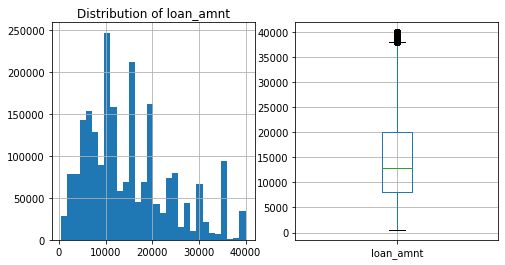

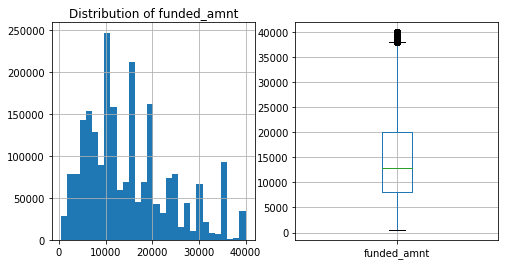

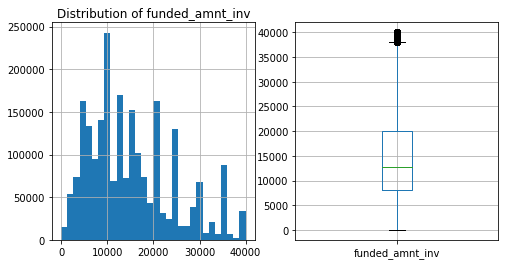

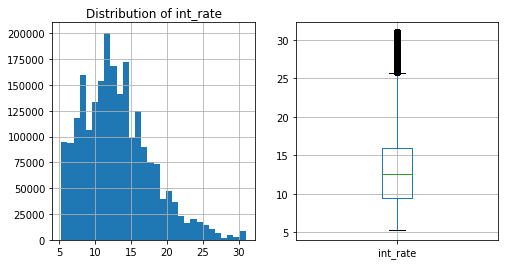

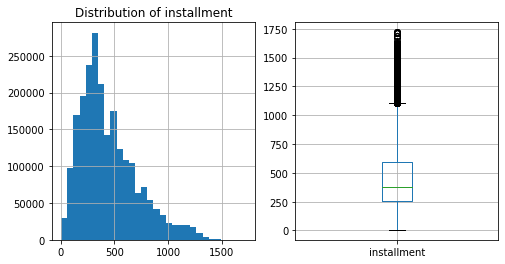

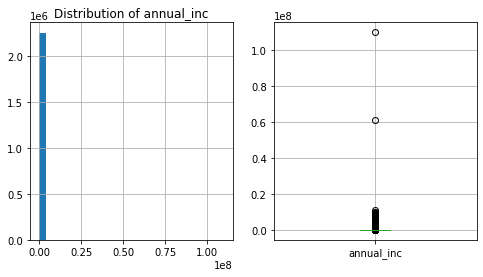

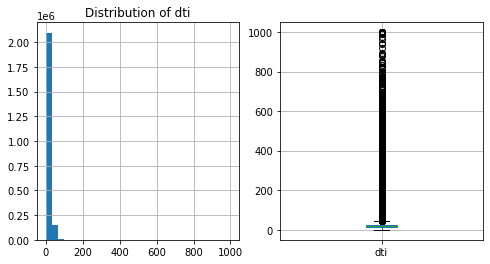

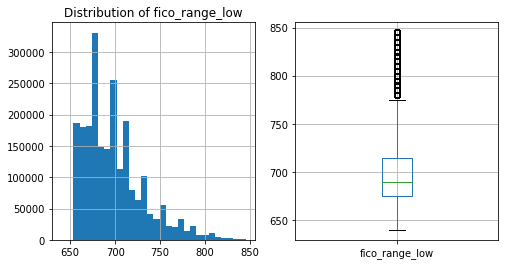

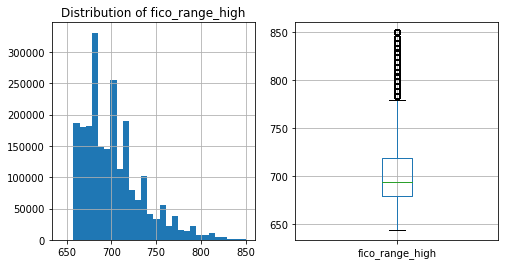

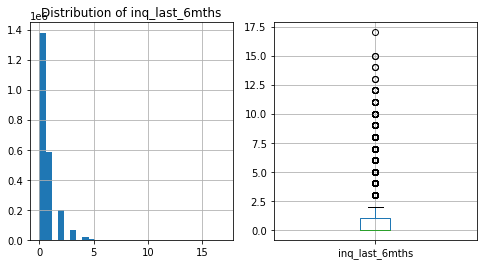

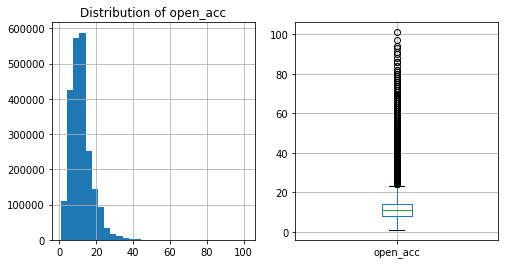

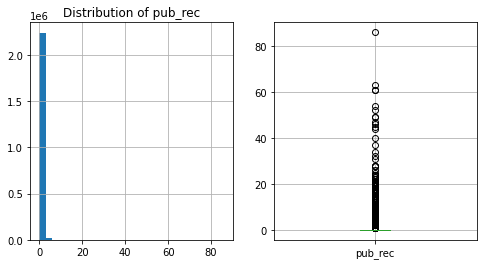

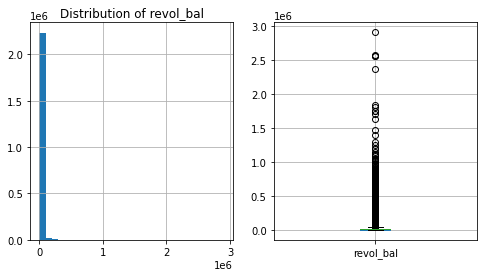

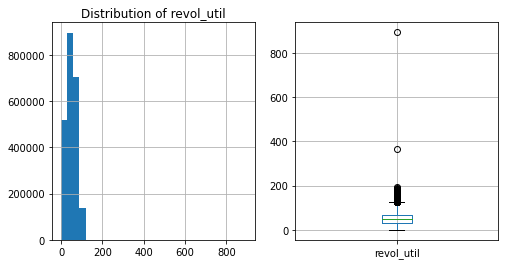

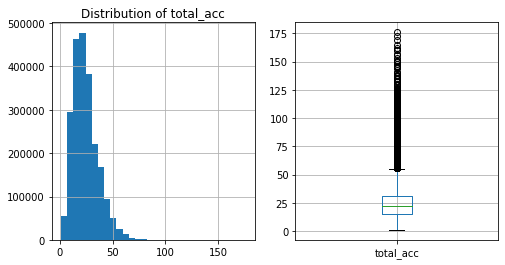

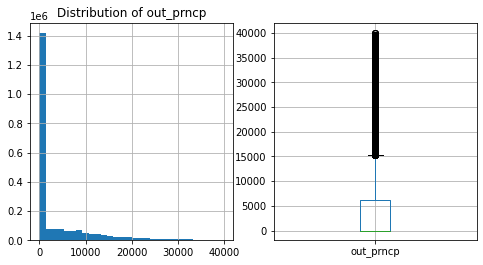

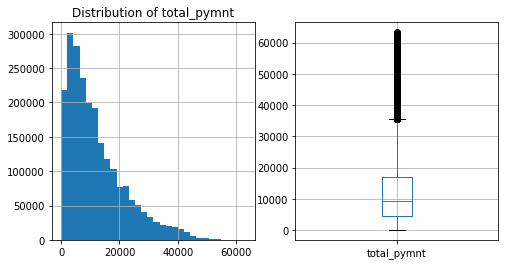

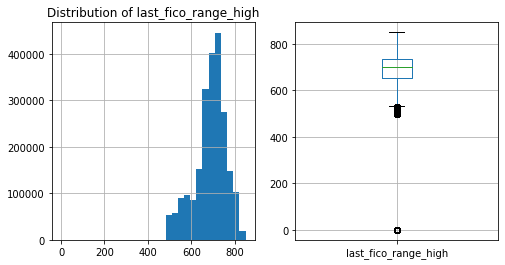

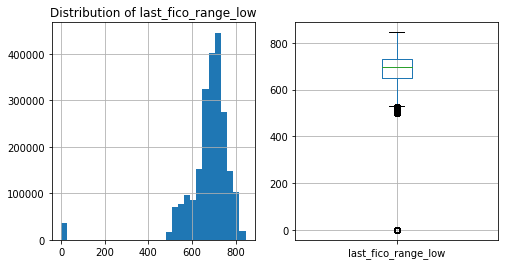

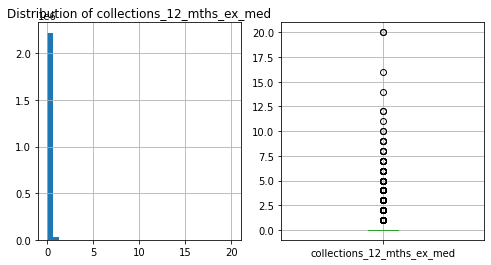

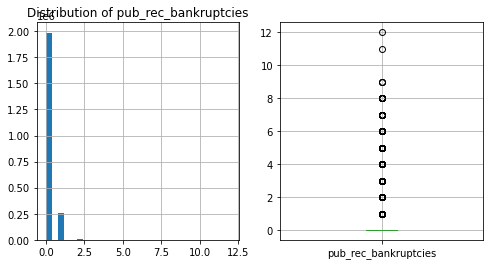

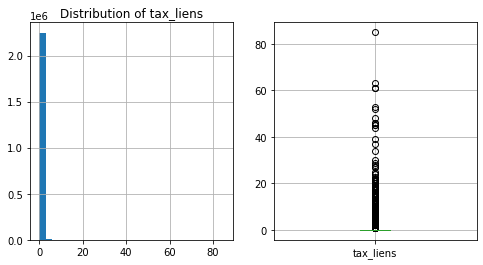

In [ ]:
# Display distribution of numeric features to observe outliers.
for col in numeric_features.tolist():
  f, axes = plt.subplots(1, 2, figsize=(8, 4)) 
  accepted_df[col].hist(bins = 30, ax = axes[0])
  axes[0].set_title('Distribution of '+ col)
  accepted_df.boxplot(column = col, ax = axes[1])
  plt.show()

**We were able to identify the following columns where outliers are present and their criteria. Eliminating them from the data may yield more accurate analyses going forward.**

In [ ]:
# Copy length of DataFrame.
b4_outlier_drop = len(accepted_df)

# Drop outliers based on values.
accepted_df.loc[accepted_df.annual_inc > 1e6, 'annual_inc'] = None
accepted_df.loc[accepted_df.pub_rec > 80, 'pub_rec'] = None
accepted_df.loc[accepted_df.revol_util > 300, 'revol_util'] = None
accepted_df.loc[accepted_df.last_fico_range_high < 200, 'last_fico_range_high'] = None
accepted_df.loc[accepted_df.last_fico_range_low < 200, 'last_fico_range_low'] = None
accepted_df.loc[accepted_df.tax_liens > 80, 'tax_liens'] = None
accepted_df.dropna(inplace=True)

if (b4_outlier_drop != len(accepted_df)):
  print(f"{color.BOLD}Row Count Before Removing Outliers: {color.END}{b4_outlier_drop}\n")
  print(f"{color.BOLD}Row Count After Removing Outliers: {color.END}{len(accepted_df)}")
else :
  print(f'{color.BOLD}~~~{color.END} Rows with Outliers Already Dropped in this Runtime. {color.BOLD}~~~{color.END}\n')
  print(f"{color.BOLD}Row Count After Removing Outliers: {color.END}{len(accepted_df):,d}")

Row Count Before Removing Outliers: 2255820

Row Count After Removing Outliers: 2218021


## Feature Engineering

> **It's important to remember our objective: help Dr. D invest his money in loans that will make him money. We decided to use Return on Investment as a measure of profitability since we want Dr. D to have his money paid back in full AND for him to make the most money possible on top of his investment. We know that loans that fail to pay off the entire principle will have an ROI less than 100% and want to find loans with returns over 100%. To do find the loans with the greatest ROIs, we had to engineer the ROI by dividing the total payment amount by the total amount funded.**

### Return on Investment (ROI)

In [ ]:
# Feature engineering 'Return' column. 
def getReturn(df, total_pymnt, funded):
  # Calculate return by dividing revenue (total_pymnt) by the loan's funded amount
  df['Return'] = df.total_pymnt / funded
  return df

# Calculate ROI for accepted_df
try:
  if ('Return' in accepted_df):
    print(purposeful_error) 
  accepted_df = getReturn(accepted_df, accepted_df.total_pymnt, accepted_df.funded_amnt)
  numeric_features = numeric_features.insert(len(numeric_features),'Return')

except:
  print(f'{color.BOLD}~~~{color.END} ROI already calculated in this runtime. {color.BOLD}~~~{color.END}')

In [ ]:
# Display 'Return' column and mean ROI
print(f"{color.BOLD}Return on Investment Column:{color.END}\n\n{accepted_df[['Return']].head(10)}")
accepted_ROI_mean = accepted_df.Return.mean()
print(f"\n{color.BOLD}Mean ROI for Accepted Loan Data:{color.END} {round((accepted_ROI_mean-1)*100,2)} %\n")

Return on Investment Column:

     Return
0  1.228257
1  1.039662
2  1.135296
3  0.898972
4  1.128894
5  1.147192
6  1.069690
7  1.076925
8  1.099897
9  1.117448

Mean ROI for Accepted Loan Data: -17.13 %



**Above, you can see the Mean ROI for all accepted loans is about -17%**

### Categorical ROI

**Here, we encode our target variables as categorical variables so they become machine readable. The categories are loans with over 100% ROI, over a 110% ROI and over a 120% ROI.**

In [ ]:
# Create categorical variables for 0%, 7.5%, 10%, and 20% return
def getROI_100(df, total_pymnt, funded):
  df['roi_100'] = (df['Return'] > 1.0)
  return df

def getROI_1075(df, total_pymnt, funded):
  df['roi_107.5'] = (df['Return'] > 1.075)
  return df

def getROI_110(df, total_pymnt, funded):
  df['roi_110'] = (df['Return'] > 1.1)
  return df

def getROI_120(df, total_pymnt, funded):
  df['roi_120'] = (df['Return'] > 1.2)
  return df

# Add the columns.
accepted_df = getROI_100(accepted_df, accepted_df.total_pymnt, accepted_df.funded_amnt)
accepted_df = getROI_1075(accepted_df, accepted_df.total_pymnt, accepted_df.funded_amnt)
accepted_df = getROI_110(accepted_df, accepted_df.total_pymnt, accepted_df.funded_amnt)
accepted_df = getROI_120(accepted_df, accepted_df.total_pymnt, accepted_df.funded_amnt)

# Map them to 0 or 1
repmap={True: 1, False: 0}
accepted_df['roi_100'].replace(repmap, inplace=True)
accepted_df['roi_107.5'].replace(repmap, inplace=True)
accepted_df['roi_110'].replace(repmap, inplace=True)
accepted_df['roi_120'].replace(repmap, inplace=True)

display(accepted_df[['Return','roi_100','roi_107.5','roi_110','roi_120']].sample(n=10, random_state = 42))

,Return,roi_100,roi_107.5,roi_110,roi_120
148469,1.176796,1,1,1,0
1064024,1.146963,1,1,1,0
1362642,0.090995,0,0,0,0
631175,0.616256,0,0,0,0
1252353,1.204153,1,1,1,1
1439598,0.161912,0,0,0,0
1243010,1.392185,1,1,1,1
1454990,0.162607,0,0,0,0
212891,1.247262,1,1,1,1
1815003,1.263474,1,1,1,1


## Reduce to Closed Loan Data




**We can have our model determine whether or not a completed loan will be either fully paid or charged off. To do this, we drop the current loan data since they have yet to come to a fully paid or charged off conclusion. We decided to remove the "Default" column in the closed dataframe because only 39 loans out of more than 2 million had defaulted, and defaulting and charging off are synonymous. We removed the loans that didn't meet the credit policy because we want Dr. D to only invest his money in loans with recipients who could pay him back and meet the bare minimum requirements for doing so.**

**Later, we will find the main characteristics of fully paid loans and then find which other indicators among these loans are likely to generate a high ROI for Dr. D.**



In [ ]:
# loan_status is our target variable. We will only be splitting the DataFrames based on whether they are Current or Closed
print(f'{color.BOLD}Count of Values for loan_status of All Accepted Loans:{color.END}\n')
print(accepted_df['loan_status'].value_counts())

# Split DataFrame into Current and Closed category.
closed_df = accepted_df.copy()

# Drop unneeded rows that don't meet this description
closed_df.drop(closed_df[closed_df['loan_status'] == 'Current'].index, inplace=True)
closed_df.drop(closed_df[closed_df['loan_status'] == 'Late (31-120 days)'].index, inplace=True)
closed_df.drop(closed_df[closed_df['loan_status'] == 'In Grace Period'].index, inplace=True)
closed_df.drop(closed_df[closed_df['loan_status'] == 'Late (16-30 days)'].index, inplace=True)
closed_df.drop(closed_df[closed_df['loan_status'] == 'Default'].index, inplace=True)
closed_df.drop(closed_df[closed_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid'].index, inplace=True)
closed_df.drop(closed_df[closed_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off'].index, inplace=True)

print(f'\n{color.BOLD}Count of Values for loan_status of Closed Loans:{color.END}\n')
print(closed_df['loan_status'].value_counts())

Count of Values for loan_status of All Accepted Loans:

Fully Paid                                             1070206
Current                                                 875352
Charged Off                                             237058
Late (31-120 days)                                       20647
In Grace Period                                           8390
Late (16-30 days)                                         4316
Does not meet the credit policy. Status:Fully Paid        1509
Does not meet the credit policy. Status:Charged Off        504
Default                                                     39
Name: loan_status, dtype: int64

Count of Values for loan_status of Closed Loans:

Fully Paid                                             1070206
Charged Off                                             237058
Late (31-120 days)                                           0
Late (16-30 days)                                            0
In Grace Period                           

**By summing up 'out_prncp' and 'pymnt_plan', we can see they are zero for every row in the closed loan data. Thus, we will drop them.**

In [ ]:
# out_prncp and pymnt_plan are zero for every closed loan
# out_prncp: Remaining outstanding principal for total amount funded

try:
  print(f"{color.BOLD}Sum of 'out_prncp' Column in closed_df DataFrame: {color.END}{closed_df.out_prncp.sum()}\n")

  closed_df.drop(columns = ['out_prncp'], inplace = True)

except:
  print(f"{color.BOLD}~~~ 'out_prncp'{color.END} has already been dropped in this runtime execution. {color.BOLD}~~~{color.END}\n")

try:
  print(f"{color.BOLD}Sum of 'pymnt_plan' Column in closed_df DataFrame: {color.END}{closed_df.pymnt_plan.sum()}\n")

  closed_df.drop(columns = ['pymnt_plan'], inplace = True)

except:
  print(f"{color.BOLD}~~~ 'pymnt_plan'{color.END} has already been dropped in this runtime execution. {color.BOLD}~~~{color.END}\n")


print(f'{color.BOLD}Final Number of Columns for Closed Loan Data: {color.END}{len(closed_df.columns)}')

Sum of 'out_prncp' Column in closed_df DataFrame: 0.0

Sum of 'pymnt_plan' Column in closed_df DataFrame: 0.0

Final Number of Columns for Closed Loan Data: 34


## Sampling

**Sampling provides two benefits here:**

>**First, this reduces computational power and capacity needed, by randomly sampling half of the closed loan data. We will use this data to gather insights about building a model for predicting low-risk and profitable loans.**

>**Then, our second benefit is the ability to test the results of this model on a disjoint set of training data.**

Size of Closed Loans: 1,307,264

Mean ROI for All Closed Loan Data: 4.5473 %



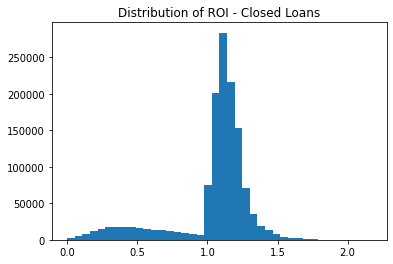


Size of Closed Loans Sample 1: 500,000

Size of Closed Loans Sample 2: 807,264


In [ ]:
print(f'{color.BOLD}Size of Closed Loans: {color.END}{closed_df.shape[0]:,d}\n')

closed_ROI_mean = closed_df.Return.mean()
print(f"{color.BOLD}Mean ROI for All Closed Loan Data:{color.END} {round(((closed_ROI_mean-1)*100),4)} %\n")

# Display distribution of ROI for closed loan data.
closed_sample_y = closed_df.Return
plt.hist(closed_sample_y, bins = 40)
plt.title('Distribution of ROI - Closed Loans')
plt.show()

# msk = np.random.rand(len(closed_df)) < 0.5

# closed_sample1 = closed_df[msk]

# closed_sample2 = closed_df[~msk]

closed_sample1 = closed_df.sample(n=500000,random_state=2)

closed_sample2 = closed_df.drop(closed_sample1.index)

print(f'\n{color.BOLD}Size of Closed Loans Sample 1: {color.END}{closed_sample1.shape[0]:,d}\n')
print(f'{color.BOLD}Size of Closed Loans Sample 2: {color.END}{closed_sample2.shape[0]:,d}')

# 3) Creating a Comparison Baseline

**To create a competitive advantage for Dr. D (why he should listen to us), we want to measure the performance of our loans to those with an A grade. The A grade indicates that Lending Club has identified the loan as being likely to be repaid in full, and we want to make sure Dr. D gets paid on time AND as much as possible.***



## Grade A Baseline

In [ ]:
# Create baseline for loans with grade A.

# Create DataFrames with sub_grade A1, A2, A3, A4, or A5
closed_gradeA1 = closed_sample2.loc[(closed_sample2['sub_grade'] == 1)]
closed_gradeA2 = closed_sample2.loc[(closed_sample2['sub_grade'] == 2)]
closed_gradeA3 = closed_sample2.loc[(closed_sample2['sub_grade'] == 3)]
closed_gradeA4 = closed_sample2.loc[(closed_sample2['sub_grade'] == 4)]
closed_gradeA5 = closed_sample2.loc[(closed_sample2['sub_grade'] == 5)]

# Concatenate these smaller DataFrames into one combined DataFrame with all grade A loans.
frames = [closed_gradeA1, closed_gradeA2, closed_gradeA3, closed_gradeA4, closed_gradeA5]
closed_gradeA = pd.concat(frames)

# Display a sample of grade A loan data.
display(closed_gradeA.sample(5))

# Calculate and display mean ROI for grade A loan data.
closed_gradeA_mean = closed_gradeA.Return.mean()
print(f"\n{color.BOLD}Mean ROI for Closed Loan Data with Grade A:{color.END} {round((closed_gradeA_mean-1)*100,2)} %")

# Calculate and display minimum ROI for grade A loan data.
closed_gradeA_min = closed_gradeA.Return.min()
print(f"\n{color.BOLD}Minimum ROI for Closed Loan Data with Grade A:{color.END} {closed_gradeA_min} %")

# Calculate and display maximum ROI for grade A loan data.
closed_gradeA_max = closed_gradeA.Return.max()
print(f"\n{color.BOLD}Maximum ROI for Closed Loan Data with Grade A:{color.END} {round((closed_gradeA_max-1)*100,2)} %")

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_pymnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,pub_rec_bankruptcies,tax_liens,Return,roi_100,roi_107.5,roi_110,roi_120
240637,10000.0,10000.0,10000.0,0.0,5.32,301.15,1.0,RENT,88000.0,Not Verified,Fully Paid,debt_consolidation,2.43,745.0,749.0,0.0,5.0,0.0,6618.0,20.6,7.0,1.0,10838.354836,784.0,780.0,0.0,0.0,0.0,0.0,1.083835,1,1,0,0
2098460,10000.0,10000.0,10000.0,0.0,7.97,313.23,5.0,OWN,16000.0,Verified,Fully Paid,other,22.73,775.0,779.0,0.0,11.0,0.0,2543.0,7.1,14.0,1.0,10142.391881,784.0,780.0,0.0,0.0,0.0,0.0,1.014239,1,0,0,0
1018929,8000.0,8000.0,8000.0,0.0,5.32,240.92,1.0,RENT,51000.0,Source Verified,Fully Paid,credit_card,1.58,690.0,694.0,0.0,12.0,1.0,4597.0,17.1,27.0,1.0,8468.470096,739.0,735.0,0.0,0.0,1.0,0.0,1.058559,1,0,0,0
123105,28000.0,28000.0,28000.0,0.0,6.24,854.87,2.0,MORTGAGE,180000.0,Source Verified,Fully Paid,credit_card,20.08,685.0,689.0,2.0,16.0,0.0,67324.0,61.0,44.0,1.0,29579.850000,729.0,725.0,0.0,0.0,0.0,0.0,1.056423,1,0,0,0
1663174,12000.0,12000.0,12000.0,0.0,7.99,375.99,5.0,RENT,90000.0,Source Verified,Fully Paid,debt_consolidation,14.83,735.0,739.0,0.0,12.0,0.0,16453.0,36.6,19.0,1.0,13316.657919,674.0,670.0,0.0,0.0,0.0,0.0,1.109721,1,1,1,0



Mean ROI for Closed Loan Data with Grade A: 5.5 %

Minimum ROI for Closed Loan Data with Grade A: 0.0 %

Maximum ROI for Closed Loan Data with Grade A: 25.32 %


**The Minimum ROI for Closed Loans with Grade A is 0%. Is this an outlier or is this a value we should expect? Let's take a look at the distribution of Return for Grade A loans.**

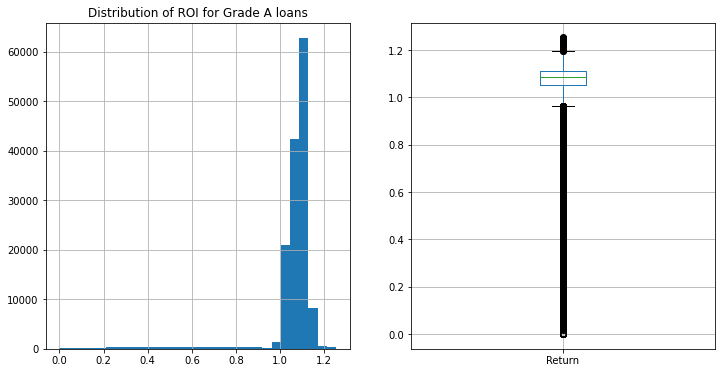

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(12, 6)) 
closed_gradeA['Return'].hist(bins = 30, ax = axes[0])
axes[0].set_title('Distribution of ROI for Grade A loans')
closed_gradeA.boxplot(column = 'Return', ax = axes[1])
plt.show()

**Let's take a closer look at Return distributions that are lower than 10%. There are over 40 instances where a Grade A loan made 0% return. Since the data isn't severly skewed and there are many loans with 0% return, we would not classify this as an outlier.**

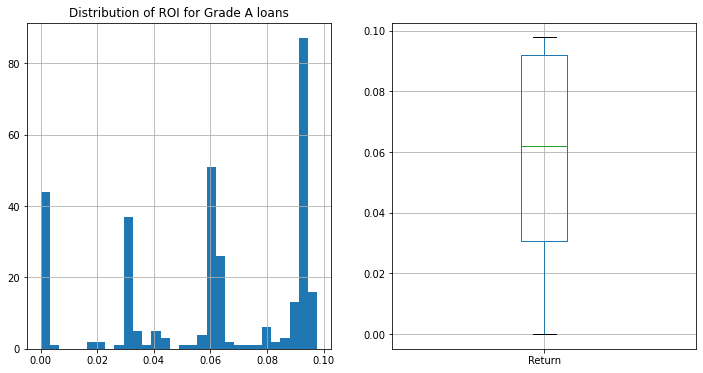

In [ ]:
low_return_gradeA = closed_gradeA.loc[closed_gradeA['Return'] < .1]
f, axes = plt.subplots(1, 2, figsize=(12, 6)) 
low_return_gradeA['Return'].hist(bins = 30, ax = axes[0])
axes[0].set_title('Distribution of ROI for Grade A loans')
low_return_gradeA.boxplot(column = 'Return', ax = axes[1])
plt.show()

**Great! We've identified a baseline of a 105% ROI on Grade A loans. Again, this would be useful if Dr. D were to either listen to us or essentially listen to what Lending Club thinks is a safe loan. Our model's performance would give Dr. D. a 5% or better return about 75% of the time!**

# 4) Correlation Analysis

## Correlation Matrix of Closed Loans


**Using the Correlation Matrix, we can take a look at variables that show a strong link to each other. We can use this to help determine which variables most influence our target variable. Also, some of the variables that are strongly correlated can be dropped.**

In [ ]:
# from sklearn.preprocessing import StandardScaler
# from sklearn import metrics, model_selection
# from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV

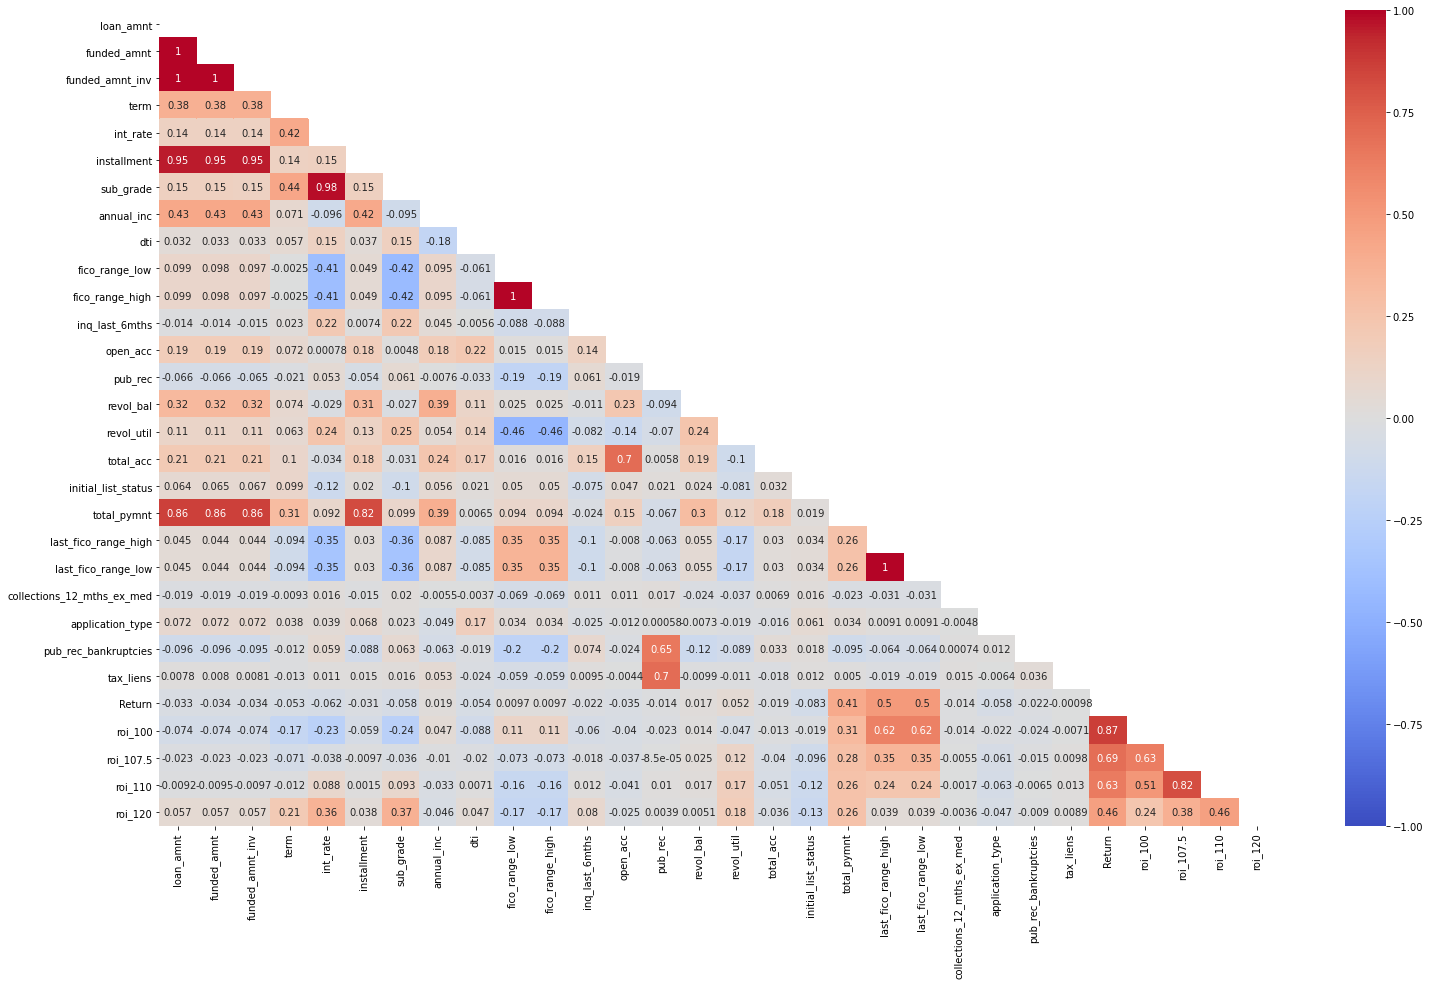

In [ ]:
# create a grouped dataframe that includes the target variable
closed_copy = closed_sample1.copy()

# create a correlation matrix from the grouped dataframe
closed_corr = closed_copy.corr()
plt.figure(figsize=(25,15))
mask = np.zeros(closed_corr.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
sns.heatmap(closed_corr, vmin = -1, vmax = 1, center = 0, cmap = 'coolwarm', annot = True, mask = mask)

# 5) Predicting Loan Status

**Using closed loan data, we can use variables we would know before before agreeing to fund the loan to find which variables will give a 'Fully Paid' loan.**

##Random Forest

Below we use a Random Forest algorithm to determine predictors for a Fully Paid loan. We chose loan status as our target variable first, as a means of reducing risk in investing in loans that may default (i.e. be "charged off").

In [ ]:
closed_X = closed_sample1.loc[:, closed_sample1.columns != 'loan_status']
closed_X = closed_X.loc[:, closed_X.columns != 'Return']
closed_X = closed_X.loc[:, closed_X.columns != 'roi_100']
closed_X = closed_X.loc[:, closed_X.columns != 'roi_107.5']
closed_X = closed_X.loc[:, closed_X.columns != 'roi_110']
closed_X = closed_X.loc[:, closed_X.columns != 'roi_120']
closed_X = closed_X.loc[:, closed_X.columns != 'total_pymnt']
closed_X = closed_X.loc[:, closed_X.columns != 'funded_amnt']
closed_X = closed_X.loc[:, closed_X.columns != 'funded_amnt_inv']
closed_Y = closed_sample1.loan_status

# Now you need to one hot encode the categorical features to make them machine readable. 
closed_X = pd.get_dummies(closed_X)

print(f"{color.BOLD}Predictor Variables for Closed Loan Data{color.END} - {closed_X.shape[1]} columns x {closed_X.shape[0]:,d} rows\n")

display(closed_X.head())
try: 
  repmap={"Fully Paid": 1, "Charged Off": 0}
  closed_Y.replace(repmap, inplace=True)
except:
  print(f"\n{color.BOLD}~~~{color.END} 'loan_status' already encoded during this runtime execution. {color.BOLD}~~~{color.END}\n")

print(f"{color.BOLD}Target Variable for Closed Loan Data{color.END} - {closed_Y.shape[0]:,d} rows\n")
display(closed_Y.head())

Predictor Variables for Closed Loan Data - 45 columns x 500,000 rows



,loan_amnt,term,int_rate,installment,sub_grade,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,pub_rec_bankruptcies,tax_liens,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
1689838,26000.0,1.0,15.99,632.14,15.0,85000.0,15.95,680.0,684.0,0.0,12.0,0.0,24021.0,71.5,16.0,1.0,699.0,695.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
266611,1500.0,0.0,9.17,47.82,7.0,75000.0,13.90,660.0,664.0,0.0,6.0,0.0,12196.0,85.9,14.0,1.0,694.0,690.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2161700,10000.0,1.0,21.49,273.30,20.0,75000.0,2.46,660.0,664.0,1.0,6.0,1.0,4060.0,66.6,14.0,1.0,594.0,590.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1055542,35000.0,0.0,14.46,1204.06,14.0,60000.0,30.86,700.0,704.0,1.0,16.0,0.0,33961.0,45.3,34.0,1.0,734.0,730.0,0.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1843022,15600.0,1.0,17.27,389.97,15.0,42000.0,14.40,710.0,714.0,1.0,5.0,0.0,9816.0,62.5,10.0,0.0,699.0,695.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Target Variable for Closed Loan Data - 500,000 rows



1689838    1
266611     1
2161700    0
1055542    1
1843022    1
Name: loan_status, dtype: int64

Above, our target variable was One Hot Encoded to make predictions easier.

In [ ]:
# Basic imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(closed_X, closed_Y,
test_size=0.3,
stratify=closed_Y,
random_state=42)

# Instantiate a random forests classifier
rf = RandomForestClassifier(n_estimators=25, 
                            bootstrap = True, 
                            max_features = 'auto', 
                            min_samples_leaf = 5, 
                            criterion='gini',
                            random_state=42)

# Fit 'rf' to the training set
rf.fit(X_train, y_train)

# Predict the test set labels 'y_pred'
y_pred = rf.predict(X_test)

R-square = 0.9069
              precision    recall  f1-score   support

           0       0.75      0.74      0.74     27204
           1       0.94      0.94      0.94    122796

    accuracy                           0.91    150000
   macro avg       0.84      0.84      0.84    150000
weighted avg       0.91      0.91      0.91    150000



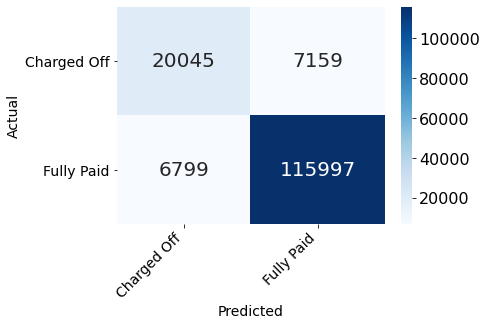

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Output the accuracy of our prediction
print(f"R-square = {round(accuracy_score(y_test, y_pred),4)}")

# Visualize the confusion matrix to make it easier to read
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('Charged Off', 'Fully Paid'), ('Charged Off', 'Fully Paid'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Our Random Forest Tree had a 90.695% accuracy score. In predicting Charged Off, the precision was 75%, the recall was 74% and the f1-score was 0.74. In regards to Fully Paid, the precision, recall, and f1-score were all 94%. 

Train ROC AUC Score: 0.9854479819003268
Test ROC AUC  Score: 0.9430298952614636
Baseline ROC AUC: 0.5
Recall Test: 0.94 Train: 0.97
Precision Test: 0.94 Train: 0.96
Roc Test: 0.94 Train: 0.99


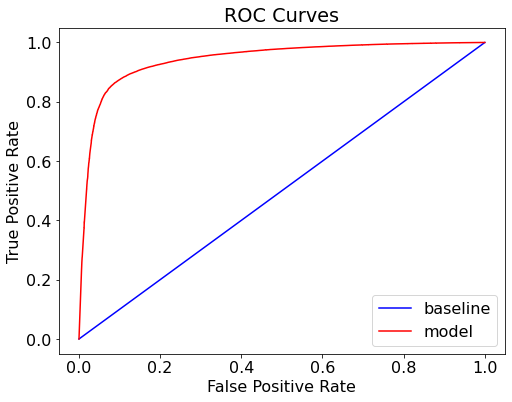

In [ ]:
# Create evaluate_model function
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

# Let's evaluate our Tree's performance unsing AUC
# Make probability predictions
train_probs = rf.predict_proba(X_train)[:, 1]
probs = rf.predict_proba(X_test)[:, 1]

train_predictions = rf.predict(X_train)
predictions = rf.predict(X_test)

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

# Call our ROC evaluation function
evaluate_model(predictions, probs, train_predictions, train_probs)

Here we've done an evaluation of our forest tree, specifically looking at the AUC / ROC score and curve. The Train ROC AUC Score was 0.985, and the Test ROC AUC Score was 0.943. 

In [ ]:
display(closed_X)

,loan_amnt,term,int_rate,installment,sub_grade,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,pub_rec_bankruptcies,tax_liens,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
1689838,26000.0,1.0,15.99,632.14,15.0,85000.0,15.95,680.0,684.0,0.0,12.0,0.0,24021.0,71.5,16.0,1.0,699.0,695.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
266611,1500.0,0.0,9.17,47.82,7.0,75000.0,13.90,660.0,664.0,0.0,6.0,0.0,12196.0,85.9,14.0,1.0,694.0,690.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2161700,10000.0,1.0,21.49,273.30,20.0,75000.0,2.46,660.0,664.0,1.0,6.0,1.0,4060.0,66.6,14.0,1.0,594.0,590.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1055542,35000.0,0.0,14.46,1204.06,14.0,60000.0,30.86,700.0,704.0,1.0,16.0,0.0,33961.0,45.3,34.0,1.0,734.0,730.0,0.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1843022,15600.0,1.0,17.27,389.97,15.0,42000.0,14.40,710.0,714.0,1.0,5.0,0.0,9816.0,62.5,10.0,0.0,699.0,695.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337118,15000.0,0.0,13.33,507.80,13.0,48880.0,22.07,675.0,679.0,0.0,10.0,0.0,12210.0,74.0,21.0,0.0,624.0,620.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1852167,12600.0,0.0,6.62,386.87,2.0,80000.0,6.29,705.0,709.0,0.0,15.0,0.0,16072.0,26.1,30.0,0.0,774.0,770.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1340238,12725.0,1.0,19.97,336.93,20.0,29000.0,26.51,680.0,684.0,0.0,25.0,0.0,10543.0,75.3,38.0,0.0,674.0,670.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1321114,10000.0,0.0,12.99,336.90,10.0,37000.0,12.39,690.0,694.0,0.0,6.0,0.0,8026.0,87.2,11.0,1.0,749.0,745.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive

# class labels
features = X_train.columns.to_list()

def plot_RF(crit, depth, bootstrap=True, min_split=6, min_leaf=5,MID=0.0, n_estimators = 25):
    
    model = RandomForestClassifier(random_state=1, 
        criterion = crit,
        max_depth = depth,
        bootstrap = bootstrap, 
        min_samples_split=min_split,
        min_samples_leaf=min_leaf,
        min_impurity_decrease=MID,
        max_features = 'auto', 
        n_estimators = n_estimators)
    model.fit(X_train, y_train)
    
    # Extract the final tree for visualization
    estimator = model.estimators_[-1]

    graph = Source(export_graphviz(estimator
      , out_file=None
      , feature_names=features
      , class_names=['Charged Off','Fully Paid']
      , rounded=True
      , filled = True))
    display(SVG(graph.pipe(format='svg')))
   
    return estimator

inter=interactive(plot_RF 
   , crit = ["gini", "entropy"]
   , depth=[2,3,4,]
   , bootstrap=[True,False]
   , min_split=(2,10)
   , min_leaf=(1,10)
   , MID=(0,0.1,0.001)
   , n_estimators=(50,200,50))

display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

Here is a visual representation of our Random Forest Tree. Our target variable is the loan status (i.e. Fully Paid or Charged Off), and we can get a visual of the gini (information gain / impurity) as well as see the different paramters used for dividing the dataset into classes.

###Feature Importance

**Next we can look at the importance of each feature in determining the prediction of the random forest. We can see that total_pymnt, last_fico_range_high, and last_fico_range_low are the top three features used to reduce impurity.** 

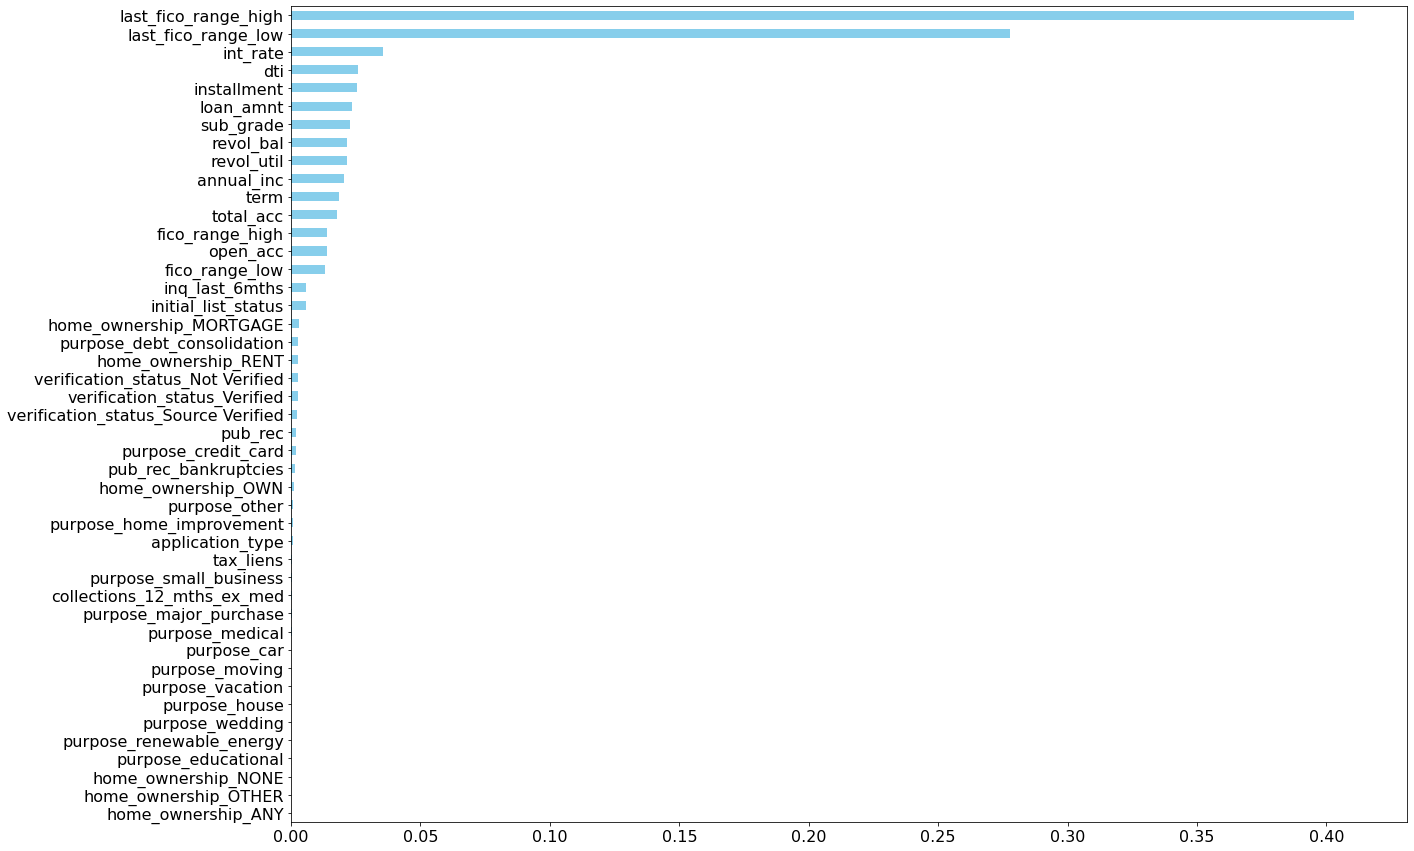

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_, index = closed_X.columns)

# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()

# Make a horizontal bar plot
plt.figure(figsize=(20,15))
sorted_importances_rf.plot(kind='barh', color='skyblue'); 
plt.show()

Our most important features include FICO ranges, interest rate, DTI, loan amount, and sub grade. A few others are identified as having high feature importance well.

In [ ]:
pred_fullyPaid = closed_sample2.loc[ (closed_sample2['loan_amnt'] >= 10012.5) &
                                    (closed_sample2['last_fico_range_high'] >= 636.5) & 
                                    (closed_sample2['int_rate'] <= 15.6)]

print(f"{color.BOLD}Values for Closed Loans where{color.END}\n")
print("   *   'loan_amnt' ≥ $ 10,012.5")
print("   *   'last_fico_range_high' ≥ 636.5")
print("   *   'int_rate' ≤ 15.6 %\n")

fp = pred_fullyPaid[pred_fullyPaid['loan_status'] == 'Fully Paid'].shape[0]
co = pred_fullyPaid[pred_fullyPaid['loan_status'] == 'Charged Off'].shape[0]

print(f"{color.BOLD}Fully Paid: {color.END}{fp:,d}")
print(f"{color.BOLD}Charged Off: {color.END}{co:,d}")


percent_fullyPaid = fp * 100 / (fp + co)
percent_fullyPaid = str(round(percent_fullyPaid,2))
print(f"\nFor loans that meet the above criteria in Closed Sample 2, {color.BOLD}{percent_fullyPaid}%{color.END} are Fully Paid.")


Values for Closed Loans where

   *   'loan_amnt' ≥ $ 10,012.5
   *   'last_fico_range_high' ≥ 636.5
   *   'int_rate' ≤ 15.6 %

Fully Paid: 256,055
Charged Off: 6,899

For loans that meet the above criteria in Closed Sample 2, 97.38% are Fully Paid.


Based on the criteria we identified previously, our model was able to identify 97.38% of closed data to be Fully Paid. This information will be used below to identify more specific criteria in determining, of the Fully Paid loans, how can we find ones with a high ROI.

# 6) Predicting ROI


**We want to find features that Dr. D can look for when trying to find profitable loans. We wouldn't know loan status when considering a loan, so we cant use this as a metric to determine profitable loans. We will also drop variables used to reduce the Closed loan data to those most likely to produce "Fully Paid" results, since we've already decided to only look at loans that meet this criteria as one of our methods of mitigating risky investments. To simplify our model, we will also drop variables "purpose," "verification_status" and "home_ownership" as they are the only non-machine-readables variables left in our closed sample data.**

## Setting Up Data

In [ ]:
try:
  # Drop features that are not known before the loan is funded.
  # Also drop features that are already included in our recommendation for ensuring a loan is Fully Paid.
  pred_fullyPaid.drop(columns = ['loan_amnt','funded_amnt','funded_amnt_inv','int_rate','total_pymnt',
                                      'last_fico_range_high','last_fico_range_low','verification_status',
                                      'loan_status','purpose','Return','roi_100'], inplace = True)
except:
  print(f"{color.BOLD}~~~{color.END} Unknown features already dropped during this runtime execution. {color.BOLD}~~~{color.END}\n")

# One-hot encode the remaining catgorical variables
pred_fullyPaid = pd.get_dummies(pred_fullyPaid)

roi_rf = pred_fullyPaid.copy()

roi_rf_Y0 = roi_rf['roi_107.5']
roi_rf_Y1 = roi_rf.roi_110
roi_rf_Y2 = roi_rf.roi_120

roi_rf_X0 = roi_rf.loc[:,roi_rf.columns != 'roi_107.5']
roi_rf_X0 = roi_rf_X0.loc[:,roi_rf_X0.columns != 'roi_110']
roi_rf_X0 = roi_rf_X0.loc[:,roi_rf_X0.columns != 'roi_120']

roi_rf_X1 = roi_rf.loc[:,roi_rf.columns != 'roi_107.5']
roi_rf_X1 = roi_rf_X1.loc[:,roi_rf_X1.columns != 'roi_110']
roi_rf_X1 = roi_rf_X1.loc[:,roi_rf_X1.columns != 'roi_120']

roi_rf_X2 = roi_rf.loc[:,roi_rf.columns != 'roi_107.5']
roi_rf_X2 = roi_rf_X2.loc[:,roi_rf_X2.columns != 'roi_110']
roi_rf_X2 = roi_rf_X2.loc[:,roi_rf_X2.columns != 'roi_120']

print(roi_rf_X1.columns)
print(roi_rf_Y1)

~~~ Unknown features already dropped during this runtime execution. ~~~

Index(['term', 'installment', 'sub_grade', 'annual_inc', 'dti',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'collections_12_mths_ex_med', 'application_type',
       'pub_rec_bankruptcies', 'tax_liens', 'home_ownership_ANY',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT'],
      dtype='object')
1          0
7          0
20         1
21         1
22         1
          ..
2260680    0
2260684    0
2260686    1
2260688    1
2260690    1
Name: roi_110, Length: 262954, dtype: int64


## Random Forest for ROI

Below we've done another Random Forest, this time with target variable ROI, to determine effective criteria for predicting investmentions with will have a high return on investment.

0.7322626034707873
              precision    recall  f1-score   support

           0       0.74      0.41      0.53     28694
           1       0.73      0.92      0.81     50193

    accuracy                           0.73     78887
   macro avg       0.73      0.66      0.67     78887
weighted avg       0.73      0.73      0.71     78887



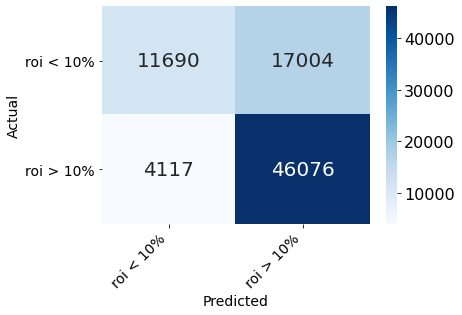

In [ ]:
# Basic imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(roi_rf_X1, roi_rf_Y1,
test_size=0.3,
random_state=42)

# Instantiate a random forests classifier
rf = RandomForestClassifier(n_estimators=25, 
                            bootstrap = True, 
                            max_features = 'auto', 
                            min_samples_leaf = 5, 
                            criterion='gini',
                            random_state=42)

# Fit 'rf' to the training set
rf.fit(X_train, y_train)

# Predict the test set labels 'y_pred'
y_pred = rf.predict(X_test)

# Output the accuracy of our prediction
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

# Visualize the confusion matrix to make it easier to read
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('roi < 10%', 'roi > 10%'), ('roi < 10%', 'roi > 10%'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Here, our target variable is the ROI being 10%, and our model achieved a 73% accuracy. The precision in determining if the ROI is greater or less than 10% is about the same, but the recall and f1 scores are signficantly lower in predicting ROI < 10%.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive

# class labels
features = X_train.columns.to_list()

def plot_RF(crit, depth, bootstrap=True, min_split=6, min_leaf=5,MID=0.0, n_estimators = 25):
    
    model = RandomForestClassifier(random_state=1, 
        criterion = crit,
        max_depth = depth,
        bootstrap = bootstrap, 
        min_samples_split=min_split,
        min_samples_leaf=min_leaf,
        min_impurity_decrease=MID,
        max_features = 'auto', 
        n_estimators = n_estimators)
    model.fit(X_train, y_train)
    
    # Extract the final tree for visualization
    estimator = model.estimators_[-1]

    graph = Source(export_graphviz(estimator
      , out_file=None
      , feature_names=features
      , class_names=['roi < 10%','roi > 10%']
      , rounded=True
      , filled = True))
    display(SVG(graph.pipe(format='svg')))
   
    return estimator

inter=interactive(plot_RF 
   , crit = ["gini", "entropy"]
   , depth=[2,3,4,]
   , bootstrap=[True,False]
   , min_split=(2,10)
   , min_leaf=(1,10)
   , MID=(0,0.1,0.001)
   , n_estimators=(50,200,50))

display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

Above, we have a visual of our Random Forest Tree in classifying loans in having an ROI greater or less than 10%.

0.8428511668589248
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     65195
           1       0.58      0.34      0.43     13692

    accuracy                           0.84     78887
   macro avg       0.73      0.64      0.67     78887
weighted avg       0.82      0.84      0.83     78887



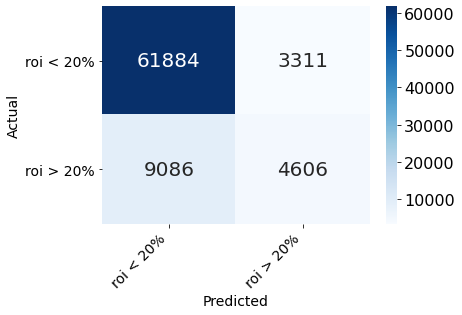

In [ ]:
# Basic imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(roi_rf_X2, roi_rf_Y2,
test_size=0.3,
random_state=42)

# Instantiate a random forests classifier
rf = RandomForestClassifier(n_estimators=25, 
                            bootstrap = True, 
                            max_features = 'auto', 
                            min_samples_leaf = 5, 
                            criterion='gini',
                            random_state=42)

# Fit 'rf' to the training set
rf.fit(X_train, y_train)

# Predict the test set labels 'y_pred'
y_pred = rf.predict(X_test)

# Output the accuracy of our prediction
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

# Visualize the confusion matrix to make it easier to read
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('roi < 20%', 'roi > 20%'), ('roi < 20%', 'roi > 20%'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Here we've done another Random Forest with a target variable of ROI, but this time predicting whether it will be greater or less than 20% returns. With about 84% accuracy, our model does do a bit better at identifying ROI < 20% versus ROI > 20%, but the insights are still useful.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive

# class labels
features = X_train.columns.to_list()

def plot_RF(crit, depth, bootstrap=True, min_split=6, min_leaf=5,MID=0.0, n_estimators = 25):
    
    model = RandomForestClassifier(random_state=1, 
        criterion = crit,
        max_depth = depth,
        bootstrap = bootstrap, 
        min_samples_split=min_split,
        min_samples_leaf=min_leaf,
        min_impurity_decrease=MID,
        max_features = 'auto', 
        n_estimators = n_estimators)
    model.fit(X_train, y_train)
    
    # Extract the final tree for visualization
    estimator = model.estimators_[-1]

    graph = Source(export_graphviz(estimator
      , out_file=None
      , feature_names=features
      , class_names=['roi < 20%','roi > 20%']
      , rounded=True
      , filled = True))
    display(SVG(graph.pipe(format='svg')))
   
    return estimator

inter=interactive(plot_RF 
   , crit = ["gini", "entropy"]
   , depth=[2,3,4,]
   , bootstrap=[True,False]
   , min_split=(2,10)
   , min_leaf=(1,10)
   , MID=(0,0.1,0.001)
   , n_estimators=(50,200,50))

display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

Above is a visual of the Random Forest classifier that is specifically for an ROI being greater or less than 20%.

# 7) Compare Model to Baseline

In [ ]:
final_df = closed_sample2.loc[ (closed_sample2['loan_amnt'] >= 10012.5) &
                              (closed_sample2['last_fico_range_high'] >= 636.5) & 
                              (closed_sample2['int_rate'] <= 16.105) &
                              (closed_sample2['fico_range_high'] <= 701.5) &
                              (closed_sample2['annual_inc'] <= 61646.0)] #&
                              # (closed_sample['sub_grade'] >= 2.5)]

pd.set_option('display.max_rows', 500)
display(final_df[['loan_status','Return']].head(10))

print(f"\n{color.BOLD}Values for Closed Loans where{color.END}\n")
print("   *   'loan_amnt' ≥ $ 10,012.5")
print("   *   'last_fico_range_high' ≥ 636.5")
print("   *   'int_rate' ≤ 16.105 %")
# print("   *   'initial_list_status' = 0 %")
print("   *   'fico_range_high' ≤ 701.5")
print("   *   'annual_inc' ≤ 61646.0\n")
print(f"{color.BOLD}Fully Paid: {color.END}{final_df['loan_status'].value_counts()[0]:,d}")
print(f"{color.BOLD}Charged Off: {color.END}{final_df['loan_status'].value_counts()[1]:,d}")

print(f"\n{color.BOLD}Return greater 0%: {color.END}{final_df['roi_100'].value_counts()[1]:,d}")
print(f"{color.BOLD}Return greater 7.5%: {color.END}{final_df['roi_107.5'].value_counts()[1]:,d}")
print(f"{color.BOLD}Return greater 10%: {color.END}{final_df['roi_110'].value_counts()[1]:,d}")
print(f"{color.BOLD}Return greater 20%: {color.END}{final_df['roi_120'].value_counts()[1]:,d}")

print(f"\n{color.BOLD}Count of Values that meet this criteria for Closed Sample 2: {color.END}{len(final_df):,d}\n")

,loan_status,Return
21,Fully Paid,1.218631
36,Fully Paid,1.299324
45,Fully Paid,1.165392
126,Fully Paid,1.218758
147,Fully Paid,1.199226
169,Fully Paid,1.182885
173,Fully Paid,1.117857
273,Fully Paid,1.186577
322,Fully Paid,1.189524
387,Fully Paid,1.083392



Values for Closed Loans where

   *   'loan_amnt' ≥ $ 10,012.5
   *   'last_fico_range_high' ≥ 636.5
   *   'int_rate' ≤ 16.105 %
   *   'fico_range_high' ≤ 701.5
   *   'annual_inc' ≤ 61646.0

Fully Paid: 39,356
Charged Off: 1,375

Return greater 0%: 39,470
Return greater 7.5%: 34,725
Return greater 10%: 31,627
Return greater 20%: 11,973

Count of Values that meet this criteria for Closed Sample 2: 40,731



Our random forest algorithms helped us to identify five specific variables with specific ranges that indicate a Fully Paid loan with a high ROI. When applying this to a subset of data, we're able to provide an 85% chance of investing in a loan with a return greater than 7.5%, a 77.6% chance of investing in a loan with a return greater than 10%, and 30% chance of investing in a loan with a return greater than 20%. 

## Model vs. Grade A Loans

Mean ROI for Closed Loan Data with Grade A: 5.5 %

Minimum ROI for Closed Loan Data with Grade A: 0.0 %

Maximum ROI for Closed Loan Data with Grade A: 25.32 %

Count of Grade A Loans: 144,080

Count of Grade A Loans with -100% Return: 44



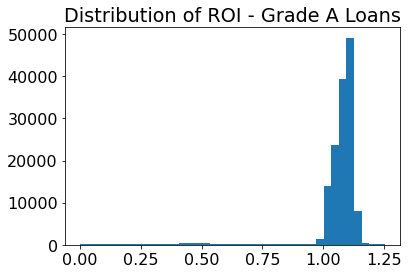


----------------------

Mean ROI for Closed Loan Data that fall in our recommendation: 14.41 %

Minimum ROI for Closed Loan Data that fall in our recommendation: 0.0 %

Maximum ROI for Closed Loan Data that fall in our recommendation: 49.25 %

Count of Grade A Loans: 40,731

Count of Grade A Loans with -100% Return: 3



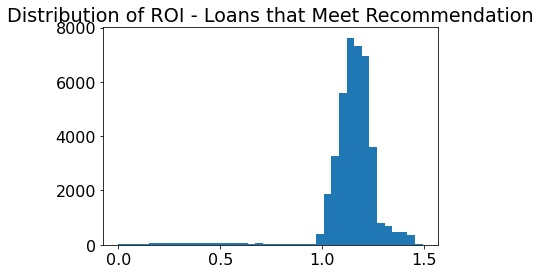

In [ ]:
# Calculate and display mean ROI for grade A loan data.
closed_gradeA_mean = closed_gradeA.Return.mean()
print(f"{color.BOLD}Mean ROI for Closed Loan Data with Grade A:{color.END} {round((closed_gradeA_mean-1)*100,2)} %")

# Calculate and display minimum ROI for grade A loan data.
closed_gradeA_min = closed_gradeA.Return.min()
print(f"\n{color.BOLD}Minimum ROI for Closed Loan Data with Grade A:{color.END} {closed_gradeA_min} %")

# Calculate and display maximum ROI for grade A loan data.
closed_gradeA_max = closed_gradeA.Return.max()
print(f"\n{color.BOLD}Maximum ROI for Closed Loan Data with Grade A:{color.END} {round((closed_gradeA_max-1)*100,2)} %")

print(f"\n{color.BOLD}Count of Grade A Loans: {color.END}{len(closed_gradeA):,d}")

zeros = closed_gradeA.loc[closed_gradeA['Return'] == 0.0]
print(f"\n{color.BOLD}Count of Grade A Loans with -100% Return: {color.END}{len(zeros)}\n")

# Display distribution of ROI for closed loan data.
gradeA_y = closed_gradeA.Return
plt.hist(gradeA_y, bins = 40)
plt.title('Distribution of ROI - Grade A Loans')
plt.show()

print('\n----------------------\n')

# Calculate and display mean ROI for grade A loan data.
final_df_mean = final_df.Return.mean()
print(f"{color.BOLD}Mean ROI for Closed Loan Data that fall in our recommendation:{color.END} {round((final_df_mean-1)*100,2)} %")

# Calculate and display minimum ROI for grade A loan data.
final_df_min = final_df.Return.min()
print(f"\n{color.BOLD}Minimum ROI for Closed Loan Data that fall in our recommendation:{color.END} {final_df_min} %")

# Calculate and display maximum ROI for grade A loan data.
final_df_max = final_df.Return.max()
print(f"\n{color.BOLD}Maximum ROI for Closed Loan Data that fall in our recommendation:{color.END} {round((final_df_max-1)*100,2)} %")

print(f"\n{color.BOLD}Count of Grade A Loans: {color.END}{len(final_df):,d}")

zeros = final_df.loc[final_df['Return'] == 0.0]
print(f"\n{color.BOLD}Count of Grade A Loans with -100% Return: {color.END}{len(zeros)}\n")

# Display distribution of ROI for closed loan data.
final_y = final_df.Return
plt.hist(final_y, bins = 40)
plt.title('Distribution of ROI - Loans that Meet Recommendation')
plt.show()


We chose our baseline for comparison to be the loans identified as Grade A by LendingTree, to get an understanding of how well our model could help someone using data-driven methods as opposed to just a blanket recomendation made by the website. The mean ROI for Grade A loans is about 5.5%. From our recommendations and criteria selection, our Mean ROI is 14.41%. Based on this high mean ROI, and our above selected criteria, we believe Dr. D will be able to make profitable returns on investments using Peer 2 Peer Lending.

# **8) Appendix**

>This is code that we used but ultimately decided not to include because it does not contribute to our final result. However, it may be helpful to look through it and see our thought process and preliminary work.

## Imputing Missing Values

**As previously mentioned, this data set is quite large so we take a smaller, random sample of the data and include the random_state so we can reproduce the results.**

In [ ]:
# It's easier to work with a smaller sample size so we take a random subset of the data. 
# Random_state is included so we can reproduce these results.
df_sampled = df.sample(n=500000,random_state=1)

NameError: ignored

In [ ]:
df_sampled.sample(10)

**Now, we impute the missing numerical data using the median as the strategy to avoid unfairly weighing outliers**

In [ ]:
from sklearn.impute import SimpleImputer

#Impute missing numerical values using Median
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
imputer = imputer.fit(df_sampled[numeric_features.tolist()])
df_sampled[numeric_features.tolist()] = imputer.transform(df_sampled[numeric_features.tolist()])

print(f'{color.BOLD}Null value counts:{color.END}\n')
print(df_sampled.isnull().sum())

**We separated our desired target variables earlier, and now we create separate dataframes for each of the targets**

In [ ]:
# create 3 separate dataframes for our target variables
fullypaid = df_sampled[df_sampled['loan_status']=='Fully Paid']
print(f'{color.BOLD}Accepted and Fully Paid:{color.END}\n\n{fullypaid}')
chargedoff = df_sampled[df_sampled['loan_status']=='Charged Off']
print(f'\n{color.BOLD}Accepted and Charged Off:{color.END}\n\n{chargedoff}')
default = df_sampled[df_sampled['loan_status']=='Default']
print(f'\n{color.BOLD}Accepted and Defaulted:{color.END}\n\n{default}')

**Here we impute the categorical variables for the feature variable dataframes from the dataframes we've already made to reduce run time. We also re-assign features to numeric and categorical since the dataframes have changed.**

In [ ]:
#Impute categorical values from the 3 dfs previously made. This reduces runtime
imputercat = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
fullypaid[categorical_features] = imputercat.fit_transform(fullypaid[categorical_features.tolist()])
chargedoff[categorical_features] = imputercat.fit_transform(chargedoff[categorical_features.tolist()])
default[categorical_features] = imputercat.fit_transform(default[categorical_features.tolist()])

print(chargedoff.isnull().sum())
print(default.isnull().sum())
print(fullypaid.isnull().sum())

In [ ]:
#concat the dataframes into one 
imputed = pd.concat([fullypaid,chargedoff,default],sort=False)

In [ ]:
#reassign features to numeric and categorical since our df changed
numeric_features = imputed.select_dtypes(include=['int64', 'float64']).columns
categorical_features = imputed.select_dtypes(include=['object', 'category']).drop(['loan_status'], axis=1).columns


for col in categorical_features.tolist():
  imputed[col] = imputed[col].astype('category')

imputed['loan_status'] = imputed['loan_status'].astype('category')    


## Correlation Matrix of Imputed DF (imputed)
 
-TODO: 
1. maybe get rid of more columns so matrix is readable. 
2. get rid of outliers


**Now we seek to conduct EDA and create a correlation matrix between the target and feature variables for both datasets with and without the imputed values. Our first step here is to instantiate our libraries and dataframes with our feature and target variables that we created earlier.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn import metrics, model_selection
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [ ]:
#make a new df including all columns except target variable
accepted_X = imputed.loc[:, imputed.columns != 'loan_status']
#drop columns that we would not have known prior to accepting a loan
accepted_X.drop(columns=['total_pymnt','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee'],inplace=True)

print(accepted_X.shape)
accepted_X.head()
#encode the categorical features and assign numeric categories to make it easier to work with
accepted_X = pd.get_dummies(accepted_X)
display(accepted_X.head())

**We're doing EDA on the imputed set first, so we create a histogram and boxplot of the feature variables to determine outliers and descriptive statistics.**

In [ ]:
for col in accepted_X.columns:
    #for each column, create space for 1 row with 2 charts 
    f, axes = plt.subplots(1, 2, figsize=(12, 6))
    #create a histogram and its title
    accepted_X[col].hist(bins = 30, ax = axes[0])
    axes[0].set_title('Distribution of '+ col)
    #create boxplot
    accepted_X.boxplot(column = col, ax = axes[1])
    plt.show()


    #how should we remove outliers?

In [ ]:
#histogram for target variable: include fully paid, charged off, default
accepted_y = imputed['loan_status']
print(accepted_y.dtype)
plt.hist(accepted_y, bins = 40)

plt.show()

In [ ]:
display(accepted_y.head())
#create a grouped dataframe that includes the target variable
grouped_df = accepted_X.copy()  
grouped_df['target'] = accepted_y.copy()
print(grouped_df.dtypes)

**To determine if there's multicollinearity between feature variables, we created a heatmap.**

In [ ]:
#create correlation matrix
corr = grouped_df.corr()
plt.figure(figsize=(180,90))
mask = np.zeros(corr.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, cmap = 'coolwarm', annot = True, mask = mask);

## Predicting All Loans

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def getClassifier(x,y):
  # Split data into 70% train and 30% test
  X_train, X_test, y_train, y_test = train_test_split(x, y,
  test_size=0.3,
  stratify=y,
  random_state=42)

  # Instantiate a random forests classifier
  rf = RandomForestClassifier(n_estimators=25, 
                              bootstrap = True, 
                              max_features = 'auto', 
                              min_samples_leaf = 5, 
                              criterion='gini',
                              random_state=42)

  # Fit 'rf' to the training set
  rf.fit(X_train, y_train)

  # Predict the test set labels 'y_pred'
  y_pred = rf.predict(X_test)
  return y_test, y_pred, rf

def getFeatureImportance(x_cols):
  # Create a pd.Series of features importances
  importances_rf = pd.Series(rf.feature_importances_, index = x_cols)

  # Sort importances_rf
  sorted_importances_rf = importances_rf.sort_values()
  print(sorted_importances_rf)
  # Make a horizontal bar plot
  plt.figure(figsize=(200,133))
  sorted_importances_rf.plot(kind='barh', color='skyblue'); 
  plt.show()


sampled = accepted_df.copy(deep=True)
index_names = sampled[(sampled['loan_status'] == 'Default') | 
                      (sampled['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid') | 
                      (sampled['loan_status'] == 'Does not meet the credit policy. Status:Charged Off')].index
sampled.drop(index_names, inplace = True)
sampled = sampled.sample(n=500000,random_state=2)
all_x = sampled.loc[:, sampled.columns != 'loan_status']
all_x = all_x.loc[:, all_x.columns != 'Return']
all_x = all_x.loc[:, all_x.columns != 'roi_100']
all_x = all_x.loc[:, all_x.columns != 'roi_110']
all_x = all_x.loc[:, all_x.columns != 'roi_120']
all_x = all_x.loc[:, all_x.columns != 'total_pymnt']
all_y = sampled['loan_status']


# one-hot encode the rest (purpose, verification_status, home_ownership)

# closed_sample_test = closed_sample.copy()

# closed_sample_test = pd.get_dummies(closed_sample_test)

# display(closed_sample_test)

# # Encode categorical features with numerical names to make it easier to deal with
# closed_sample_X = pd.get_dummies(closed_sample_X)


all_x = pd.get_dummies(all_x)
repmap={"Fully Paid": 1, "Charged Off": 0, "Current":2, "Late (31-120 days)":3, 
        "In Grace Period":4, "Late (16-30 days)":5}
all_y.replace(repmap, inplace=True)


In [ ]:
y_test, y_pred = getClassifier(all_x,all_y)

In [ ]:
# Output the accuracy of our prediction
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

# Visualize the confusion matrix to make it easier to read
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('Charged Off', 'Fully Paid','Current','Late (31-120 days)', 'In Grade Period', 'Late (16-30 days)'), ('Charged Off', 'Fully Paid','Current','Late (31-120 days)', 'In Grade Period', 'Late (16-30 days)'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 10}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 10)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, zero_division=1))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive

# class labels
features = X_train.columns.to_list()

def plot_RF(crit, depth, bootstrap=True, min_split=6, min_leaf=5,MID=0.0, n_estimators = 25):
    
    model = RandomForestClassifier(random_state=1, 
        criterion = crit,
        max_depth = depth,
        bootstrap = bootstrap, 
        min_samples_split=min_split,
        min_samples_leaf=min_leaf,
        min_impurity_decrease=MID,
        max_features = 'auto', 
        n_estimators = n_estimators)
    model.fit(X_train, y_train)
    
    # Extract the final tree for visualization
    estimator = model.estimators_[-1]

    graph = Source(export_graphviz(estimator
      , out_file=None
      , feature_names=features
      , class_names=['Charged Off', 'Fully Paid','Current','Late (31-120 days)', 'In Grade Period', 'Late (16-30 days)']
      , rounded=True
      , filled = True))
    display(SVG(graph.pipe(format='svg')))
   
    return estimator

inter=interactive(plot_RF 
   , crit = ["gini", "entropy"]
   , depth=[2,3,4,]
   , bootstrap=[True,False]
   , min_split=(2,10)
   , min_leaf=(1,10)
   , MID=(0,0.1,0.001)
   , n_estimators=(50,200,50))

display(inter)

###Feature Importance

In [ ]:
getFeatureImportance(all_x.columns)

## Predicting High ROI from Closed Loans

Let's look at the Random Forest of Closed Loans with high ROIs



In [ ]:
closed_sample = closed_df.sample(n=500000,random_state=2)

closed_X = closed_sample.loc[:, closed_sample.columns != 'Return']
closed_X = closed_X.loc[:, closed_X.columns != 'roi_100']
closed_X = closed_X.loc[:, closed_X.columns != 'roi_110']
closed_X = closed_X.loc[:, closed_X.columns != 'roi_120']
closed_X = closed_X.loc[:, closed_X.columns != 'total_pymnt']
closed_Y = closed_sample.roi_100

#9 Now you need to one hot encode the categorical features to make them machine readable. 
closed_X = pd.get_dummies(closed_X)
display(closed_X.head())


# closed_X.shape
closed_Y.shape

In [ ]:
# Basic imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(closed_X, closed_Y,
test_size=0.3,
stratify=closed_Y,
random_state=42)

# Instantiate a random forests classifier
rf = RandomForestClassifier(n_estimators=25, 
                            bootstrap = True, 
                            max_features = 'auto', 
                            min_samples_leaf = 5, 
                            criterion='gini',
                            random_state=42)

# Fit 'rf' to the training set
rf.fit(X_train, y_train)

# Predict the test set labels 'y_pred'
y_pred = rf.predict(X_test)

In [ ]:
# Output the accuracy of our prediction
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

# Visualize the confusion matrix to make it easier to read
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('ROI < 100', 'ROI >= 100'), ('ROI < 100', 'ROI >= 100'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
# Let's evaluate our Tree's performance unsing AUC
# Make probability predictions
train_probs = rf.predict_proba(X_train)[:, 1]
probs = rf.predict_proba(X_test)[:, 1]

train_predictions = rf.predict(X_train)
predictions = rf.predict(X_test)

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

# Call our ROC evaluation function
evaluate_model(predictions, probs, train_predictions, train_probs)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive

# class labels
features = X_train.columns.to_list()

def plot_RF(crit, depth, bootstrap=True, min_split=6, min_leaf=5,MID=0.0, n_estimators = 25):
    
    model = RandomForestClassifier(random_state=1, 
        criterion = crit,
        max_depth = depth,
        bootstrap = bootstrap, 
        min_samples_split=min_split,
        min_samples_leaf=min_leaf,
        min_impurity_decrease=MID,
        max_features = 'auto', 
        n_estimators = n_estimators)
    model.fit(X_train, y_train)
    
    # Extract the final tree for visualization
    estimator = model.estimators_[-1]

    graph = Source(export_graphviz(estimator
      , out_file=None
      , feature_names=features
      , class_names=['ROI < 100', 'ROI >= 100']
      , rounded=True
      , filled = True))
    display(SVG(graph.pipe(format='svg')))
   
    return estimator

inter=interactive(plot_RF 
   , crit = ["gini", "entropy"]
   , depth=[2,3,4,]
   , bootstrap=[True,False]
   , min_split=(2,10)
   , min_leaf=(1,10)
   , MID=(0,0.1,0.001)
   , n_estimators=(50,200,50))

display(inter)

### Feature Importance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_, index = closed_X.columns)

# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()
print(sorted_importances_rf)
# Make a horizontal bar plot
plt.figure(figsize=(200,133))
sorted_importances_rf.plot(kind='barh', color='skyblue'); 
plt.show()

First let's look at the Random Forest for Current Loans.

In [ ]:
closed_sample = closed_df.sample(n=500000,random_state=2)
closed_X = closed_sample.loc[:, closed_sample.columns != 'loan_status']
closed_Y = closed_sample.loan_status


In [ ]:
closed_Y.shape
closed_X.shape


In [ ]:
#9 Now you need to one hot encode the categorical features to make them machine readable. 
closed_X = pd.get_dummies(closed_X)
display(closed_X.head())

repmap={"Fully Paid": 1, "Charged Off": 0}
closed_Y.replace(repmap, inplace=True)
display(closed_Y.head())

closed_X.shape
closed_Y.shape

In [ ]:
# Import models and utility functions
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Split data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(closed_X, closed_Y, test_size=0.3,
stratify=closed_Y,                                                    
random_state=42)

# Instantiate a classification-tree 'dt'
dt = DecisionTreeClassifier(criterion='gini')

# Instantiate a BaggingClassifier 'bc'
bc = BaggingClassifier(base_estimator=dt, n_estimators=25, n_jobs=-1,random_state=42)

# Fit 'bc' to the training set
bc.fit(X_train, y_train)

# Predict test set labels
y_pred = bc.predict(X_test)

# Evaluate and print test-set accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of Bagging Classifier: {:.3f}'.format(accuracy))

In [ ]:
print(y_pred)

In [ ]:
# Output the accuracy of our prediction
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

# Visualize the confusion matrix to make it easier to read
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('Charged Off', 'Default','Fully Paid'), ('Charged Off', 'Default','Fully Paid'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, zero_division=1))

The number of defaulted loans in the original dataset was 40 out of 2million. In the test dataset there are only 3 defaulted loans, making it relatively insignificant. Should we remove it from our analyses going forward?

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive

# class labels
features = X_train.columns.to_list()

def plot_RF(crit, depth, bootstrap=True, min_split=6, min_leaf=5,MID=0.0, n_estimators = 25):
    
    model = RandomForestClassifier(random_state=1, 
        criterion = crit,
        max_depth = depth,
        bootstrap = bootstrap, 
        min_samples_split=min_split,
        min_samples_leaf=min_leaf,
        min_impurity_decrease=MID,
        max_features = 'auto', 
        n_estimators = n_estimators)
    model.fit(X_train, y_train)
    
    # Extract the final tree for visualization
    estimator = model.estimators_[-1]

    graph = Source(export_graphviz(estimator
      , out_file=None
      , feature_names=features
      , class_names=['Loan_Y','Loan_N']
      , rounded=True
      , filled = True))
    display(SVG(graph.pipe(format='svg')))
   
    return estimator

inter=interactive(plot_RF 
   , crit = ["gini", "entropy"]
   , depth=[2,3,4,]
   , bootstrap=[True,False]
   , min_split=(2,10)
   , min_leaf=(1,10)
   , MID=(0,0.1,0.001)
   , n_estimators=(50,200,50))

display(inter)

##Predicting High ROI from Current Loans

Let's look at the Random Forest of Closed Loans with high ROIs



In [ ]:
current_sample = current_df.sample(n=500000,random_state=2)

current_X = current_sample.loc[:, current_sample.columns != 'Return']
current_X = current_X.loc[:, current_X.columns != 'roi_100']
current_X = current_X.loc[:, current_X.columns != 'roi_110']
current_X = current_X.loc[:, current_X.columns != 'roi_120']
current_X = current_X.loc[:, current_X.columns != 'total_pymnt']
current_Y = current_sample.roi_100

#9 Now you need to one hot encode the categorical features to make them machine readable. 
current_X = pd.get_dummies(current_X)
display(current_X.head())

In [ ]:
# Basic imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(current_X, current_Y,
test_size=0.3,
stratify=current_Y,
random_state=42)

# Instantiate a random forests classifier
rf = RandomForestClassifier(n_estimators=25, 
                            bootstrap = True, 
                            max_features = 'auto', 
                            min_samples_leaf = 5, 
                            criterion='gini',
                            random_state=42)

# Fit 'rf' to the training set
rf.fit(X_train, y_train)

# Predict the test set labels 'y_pred'
y_pred = rf.predict(X_test)

In [ ]:
# Output the accuracy of our prediction
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

# Visualize the confusion matrix to make it easier to read
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('ROI < 100', 'ROI >= 100'), ('ROI < 100', 'ROI >= 100'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
# Let's evaluate our Tree's performance unsing AUC
# Make probability predictions
train_probs = rf.predict_proba(X_train)[:, 1]
probs = rf.predict_proba(X_test)[:, 1]

train_predictions = rf.predict(X_train)
predictions = rf.predict(X_test)

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

# Call our ROC evaluation function
evaluate_model(predictions, probs, train_predictions, train_probs)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive

# class labels
features = X_train.columns.to_list()

def plot_RF(crit, depth, bootstrap=True, min_split=6, min_leaf=5,MID=0.0, n_estimators = 25):
    
    model = RandomForestClassifier(random_state=1, 
        criterion = crit,
        max_depth = depth,
        bootstrap = bootstrap, 
        min_samples_split=min_split,
        min_samples_leaf=min_leaf,
        min_impurity_decrease=MID,
        max_features = 'auto', 
        n_estimators = n_estimators)
    model.fit(X_train, y_train)
    
    # Extract the final tree for visualization
    estimator = model.estimators_[-1]

    graph = Source(export_graphviz(estimator
      , out_file=None
      , feature_names=features
      , class_names=['ROI < 100', 'ROI >= 100']
      , rounded=True
      , filled = True))
    display(SVG(graph.pipe(format='svg')))
   
    return estimator

inter=interactive(plot_RF 
   , crit = ["gini", "entropy"]
   , depth=[2,3,4,]
   , bootstrap=[True,False]
   , min_split=(2,10)
   , min_leaf=(1,10)
   , MID=(0,0.1,0.001)
   , n_estimators=(50,200,50))

display(inter)

###Feature Importance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_, index = current_X.columns)

# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()
print(sorted_importances_rf)
# Make a horizontal bar plot
plt.figure(figsize=(200,133))
sorted_importances_rf.plot(kind='barh', color='skyblue'); 
plt.show()

## Decision Trees 

### Classification Tree

In [ ]:
# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# Import train_test_split
from sklearn.model_selection import train_test_split

# Import accuracy_score
from sklearn.metrics import accuracy_score

In [ ]:
print(accepted_df['loan_status'].value_counts())

In [ ]:
# Split dataset into 80% train, 20% test
sampled = accepted_df.copy(deep=True)
index_names = sampled[(sampled['loan_status'] == 'Default') | 
                      (sampled['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid') | 
                      (sampled['loan_status'] == 'Does not meet the credit policy. Status:Charged Off')].index
sampled.drop(index_names, inplace = True)
sampled = sampled.sample(n=500000,random_state=2)

dc_x = sampled.loc[:, sampled.columns != 'loan_status']
dc_x = sampled.loc[:, sampled.columns != 'total_pymnt']
dc_x = sampled.loc[:, sampled.columns != 'Return']
dc_x = sampled.loc[:, sampled.columns != 'roi_100']
dc_x = sampled.loc[:, sampled.columns != 'roi_110']
dc_x = sampled.loc[:, sampled.columns != 'roi_120']
dc_y = sampled['loan_status']


dc_x = pd.get_dummies(dc_x)
repmap={"Fully Paid": 1, "Charged Off": 0, "Current":2, "Late (31-120 days)":3, 
        "In Grace Period":4, "Late (16-30 days)":5}
dc_y.replace(repmap, inplace=True)



X_train, X_test, y_train, y_test= train_test_split(dc_x, dc_y,
test_size=0.2,
stratify= dc_y,
random_state=42)


In [ ]:
# Instantiate dt, set 'criterion' to 'gini'
dt = DecisionTreeClassifier(criterion='gini', random_state=42)

In [ ]:
# Fit dt to the training set
dt.fit(X_train,y_train)

# Predict test-set labels
y_pred= dt.predict(X_test)

In [ ]:
# Output the accuracy of our prediction
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

# Visualize the confusion matrix to make it easier to read
from sklearn.metrics import confusion_matrix
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('Charged Off', 'Fully Paid','Current','Late (31-120 days)', 'In Grace Period','Late (16-30 days)'), ('Charged Off', 'Fully Paid','Current','Late (31-120 days)', 'In Grace Period','Late (16-30 days)'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 10}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 10)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

# code the features so we can see them
features = list(dc_x.columns)

# generate the graph
graph = Source(tree.export_graphviz(dt, 
      out_file=None, feature_names=features, 
      class_names=['Charged Off', 'Fully Paid', 'Current', 'Late (31-120)', 
                   'In Grace Period', 'Late (16-30 days)'], filled = True))

#display the graph
display(SVG(graph.pipe(format='svg')))

## Split into Closed and Current Loan Data

In [ ]:
# loan_status is our target variable. We will only be splitting the DataFrames based on whether they are Current or Closed
print(f'{color.BOLD}Count of Values for loan_status of All Accepted Loans:{color.END}\n')
print(accepted_df['loan_status'].value_counts())

# Split DataFrame into Current and Closed category.
current_df = accepted_df.copy()
closed_df = accepted_df.copy()

# Drop unneeded rows that don't meet this description
closed_df.drop(closed_df[closed_df['loan_status'] == 'Current'].index, inplace=True)
closed_df.drop(closed_df[closed_df['loan_status'] == 'Late (31-120 days)'].index, inplace=True)
closed_df.drop(closed_df[closed_df['loan_status'] == 'In Grace Period'].index, inplace=True)
closed_df.drop(closed_df[closed_df['loan_status'] == 'Late (16-30 days)'].index, inplace=True)
closed_df.drop(closed_df[closed_df['loan_status'] == 'Default'].index, inplace=True)
closed_df.drop(closed_df[closed_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid'].index, inplace=True)
closed_df.drop(closed_df[closed_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off'].index, inplace=True)

current_df.drop(closed_df[closed_df['loan_status'] == 'Fully Paid'].index, inplace=True)
current_df.drop(closed_df[closed_df['loan_status'] == 'Charged Off'].index, inplace=True)
current_df.drop(current_df[current_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid'].index, inplace = True)
current_df.drop(current_df[current_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off'].index, inplace = True)
current_df.drop(current_df[current_df['loan_status'] == 'Default'].index, inplace = True)

print(f'\n{color.BOLD}Count of Values for loan_status of Closed Loans:{color.END}\n')
print(closed_df['loan_status'].value_counts())

print(f'\n{color.BOLD}Count of Values for loan_status of Current Loans:{color.END}\n')
print(current_df['loan_status'].value_counts())

In [ ]:
# out_prncp is zero for every closed loan
# out_prncp: Remaining outstanding principal for total amount funded

try:
  print(f"{color.BOLD}Sum of 'out_prncp' Column in closed_df DataFrame: {color.END}{closed_df.out_prncp.sum()}\n")

  closed_df.drop(columns = ['out_prncp'], inplace = True)

except:
  print(f"{color.BOLD}~~~{color.END} 'out_prncp' has already been dropped in this runtime execution. {color.BOLD}~~~{color.END}\n")

print(f'{color.BOLD}Final Number of Columns for Closed Loan Data: {color.END}{len(closed_df.columns)}\n')
print(f'{color.BOLD}Final Number of Columns for Current Loan Data: {color.END}{len(current_df.columns)}')

## Sampling

**We sampled 500,000 closed loans and observed the distribution of their ROIs**

### Closed Loans

In [ ]:
print(f'{color.BOLD}Size of Closed Loans: {color.END}{closed_df.shape[0]:,d}\n')

closed_sample = closed_df.sample(n=500000,random_state=1)
print(f'{color.BOLD}Size of Closed Loans Sample: {color.END}{closed_sample.shape[0]:,d}\n')

closed_ROI_mean = closed_df.Return.mean()
print(f"{color.BOLD}Mean ROI for Closed Loan Data:{color.END} {closed_ROI_mean}\n")

# Display distribution of ROI for closed loan data.
closed_sample_y = closed_sample.Return
plt.hist(closed_sample_y, bins = 40)
plt.title('Distribution of ROI - Closed Loans')
plt.show()

**It appears that the vast majority of loans have an ROI of between 100% and 1.25%. **

### Current Loans

// need this? **no**

In [ ]:
print(f'{color.BOLD}Size of Current Loans: {color.END}{current_df.shape[0]:,d}\n')

current_sample = current_df.sample(n=500000,random_state=1)
print(f'{color.BOLD}Size of Current Loans Sample: {color.END}{current_sample.shape[0]:,d}\n')

current_ROI_mean = current_df.Return.mean()
print(f"{color.BOLD}Mean ROI for Current Loan Data:{color.END} {current_ROI_mean}\n")

# Display distribution of ROI for current loan data.
current_sample_y = current_sample.Return
plt.hist(current_sample_y, bins = 40)
plt.title('Distribution of ROI - Current Loans')
plt.show()

//TODO: why this makes sense

## Correlation Matrix of Current Loans

In [ ]:
# create a grouped dataframe that includes the target variable
current_copy = current_sample.copy()

# create a correlation matrix from the grouped dataframe
current_corr = current_copy.corr()
plt.figure(figsize=(20,10))
mask = np.zeros(current_corr.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
sns.heatmap(current_corr, vmin = -1, vmax = 1, center = 0, cmap = 'coolwarm', annot = True, mask = mask)

From this matrix, we can see that ROI and several other variables have a positive correlation...TODO

In [ ]:
# this displays distribution of values for each column

# # Encode categorical features with numerical names to make it easier to deal with
# closed_sample_X = pd.get_dummies(closed_sample_X)

# i = 0
# for col in closed_sample_X.columns:
#   print(i)
#   # for each column we create space for 1 row with 2 charts 
#   f, axes = plt.subplots(1, 2, figsize=(12, 6))
#   # create histogram and title 
#   closed_sample_X[col].hist(bins = 30, ax = axes[0])
#   axes[0].set_title('Distribution of '+ col)
#   # create boxplot 
#   closed_sample_X.boxplot(column = col, ax = axes[1])
#   i +=1
#   plt.show()

## Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

print(closed_ridge_X.columns)
# one hot encode remaining categorical variables
closed_ridge_X = pd.get_dummies(closed_ridge_X)

print(closed_ridge_X.columns)

# Split data into 50% train and 50% test
X_train, X_test, y_train, y_test = train_test_split(closed_ridge_X, closed_ridge_Y,
test_size=0.3,
random_state=1)

ridge = Ridge(alpha=1).fit(X_train, y_train)
# ridge_pred = ridge.predict(X_test)
ridge.score(X_test, y_test)

In [ ]:
# Base model
lm = Ridge(alpha=0)
lm.fit(X_train, y_train)

# Create dataframe for our test
ridge_df = pd.DataFrame({'variable': closed_ridge_X.columns, 'estimate': lm.coef_})
ridge_train_pred = []
ridge_test_pred = []

# set range of alphas to test
alphas = np.arange(0, 200, 1)

# create a loop that runs ridge regression with every value of alpha we secified above
for alpha in alphas:
    lm = Ridge(alpha=alpha)
    lm.fit(X_train, y_train)
    var_name = 'estimate' + str(alpha)
    ridge_df[var_name] = lm.coef_
    # prediction
    ridge_train_pred.append(lm.predict(X_train))
    ridge_test_pred.append(lm.predict(X_test))

print(closed_ridge_X.columns)

# Consolidate results and plot for select variables    
ridge_df = ridge_df.set_index('variable').T.rename_axis('estimate').rename_axis(None, axis=1).reset_index()
fig, ax = plt.subplots(figsize=(16, 8))
# ax.plot(ridge_df.installment, 'gray', ridge_df.sub_grade, 'lightcoral', ridge_df.annual_inc, 'maroon', ridge_df.dti, 'red')
ax.plot(ridge_df.home_ownership_ANY, 'navy', ridge_df.home_ownership_MORTGAGE, 'mediumslateblue', ridge_df.home_ownership_NONE, 'blueviolet',
        ridge_df.home_ownership_OTHER, 'purple', ridge_df.home_ownership_OWN, 'fuchsia', ridge_df.home_ownership_RENT, 'pink')

        # ridge_df.fico_range_low, 'sienna', ridge_df.fico_range_high, 'darkorange', ridge_df.inq_last_6mths, 'tan', ridge_df.open_acc, 'goldenrod',
        # ridge_df.pub_rec, 'gold', ridge_df.revol_bal, 'yellow', ridge_df.revol_util, 'lawngreen', ridge_df.total_acc, 'darkgreen',
        # ridge_df.initial_list_status, 'turquoise', ridge_df.last_fico_range_low, 'teal', ridge_df.collections_12_mths_ex_med, 'deepskyblue', 
        # ridge_df.application_type, 'steelblue', ridge_df.pub_rec_bankruptcies, 'lightsteelblue', ridge_df.tax_liens, 'royalblue',
        # ridge_df.home_ownership_ANY, 'navy', ridge_df.home_ownership_MORTGAGE, 'mediumslateblue', ridge_df.home_ownership_NONE, 'blueviolet',
        # ridge_df.home_ownership_OTHER, 'purple', ridge_df.home_ownership_OWN, 'fuchsia', ridge_df.home_ownership_RENT, 'pink')
ax.axhline(y=0, color='black')
ax.set_xlabel("Alpha")
ax.set_ylabel("Beta Estimate")
ax.set_title("Ridge Regression Trace", fontsize=16)
# ax.legend(labels=['installment','sub_grade','annual_inc','dti'])
ax.legend(labels=['Any','Mortgage','None','Other','Own', 'Rent'])
ax.grid(True)

## Lasso Regression

In [ ]:
# more data cleaning

closed_lasso_X = closed_sample1.copy()

closed_lasso_X.drop(columns = ['loan_amnt','funded_amnt','funded_amnt_inv','int_rate','total_pymnt',
                               'last_fico_range_high','last_fico_range_low','loan_status','Return','roi_100','roi_110','roi_120'], inplace = True)

closed_lasso_Y = closed_sample.loc[:,'Return']

closed_ridge_X = pd.get_dummies(closed_lasso_X)

display(len(closed_lasso_X.columns))

In [ ]:
# rescale the data

from sklearn.preprocessing import StandardScaler

numeric_columns = closed_lasso_X.select_dtypes(include=['int64', 'float64']).columns

def scale_numeric(data, numeric_columns, scaler):
    for col in numeric_columns:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data

# we can now define the scaler we want to use and apply it to our dataset 
scaler = StandardScaler()
closed_lasso_X = scale_numeric(closed_lasso_X, numeric_columns, scaler)

print(closed_lasso_X)

# split into train and test
from sklearn import metrics, model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(closed_lasso_X, closed_lasso_Y, test_size = 0.4, random_state = 42)

# get shape of test and training sets
print('Training Set:')
print('Number of records: ', X_train.shape[0])
print('Number of features: ', X_train.shape[1])
print('\n')
print('Test Set:')
print('Number of records: ', X_test.shape[0])
print('Number of features: ', X_test.shape[1])

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV

lm = LinearRegression()
lm.fit(X_train, y_train)
linear1_coeff = lm.coef_.copy()
coeff_perm = np.flipud(np.argsort(linear1_coeff))
plt.figure(figsize=(12,6))
plt.plot(linear1_coeff[coeff_perm])
plt.ylabel('Coefficients')
plt.xticks(range(closed_lasso_X.columns.size), closed_lasso_X.columns.values[coeff_perm], rotation=60)
plt.show()

def evaluate(y_test, y_pred):
    # this block of code returns all the metrics we are interested in 
    mse = metrics.mean_squared_error(y_test, y_pred)
    msa = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)

    print("Mean squared error: ", mse)
    print("Mean absolute error: ", msa)
    print("R^2 : ", r2)
    
    # this creates a chart plotting predicted and actual 
    plt.figure(figsize=(8,8))
    plt.scatter(y_test, y_pred)
    plt.xlabel("ROI: $y_i$")
    plt.ylabel("Predicted ROI: $\hat{y}_i$")
    plt.title("ROI vs Predicted ROI: $y_i$ vs $\hat{y}_i$")

lm = Lasso(alpha = .0001)
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
evaluate(y_test, y_pred)
lasso01_coeff = lm.coef_.copy()

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(lasso01_coeff[coeff_perm])
plt.legend(['lass0.1'])
plt.ylabel('Coefficients')
plt.xticks(range(closed_ridge_X.columns.size), closed_ridge_X.columns.values[coeff_perm], rotation=60)
plt.show()